# Import libraries

In [1]:
import os
import pickle as pkl

import pandas as pd
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

SAVE = False 
if SAVE:
    OUTPUT_PATH = "/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  
    
import sklearn
import scanpy as sc
import seaborn as sns

import gseapy as gp
from gseapy.plot import gseaplot
import matplotlib.pylab as plt
from adjustText import adjust_text

from matplotlib_venn import venn2, venn3
from matplotlib.lines import Line2D

from pandas.io.formats.style import Styler
from sklearn import datasets, preprocessing, decomposition, model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from gseapy import Msigdb
from matplotlib.ticker import FixedLocator
from scipy.stats import zscore

In [2]:
import matplotlib.patches as mpatches

In [3]:
from matplotlib.ticker import MultipleLocator

In [4]:
from gseapy import GSEA

In [5]:
from venn import venn

In [6]:
#from matplotlib_venn import venn3_unweighted 

In [7]:
#pd.set_option('display.max_colwidth', None)

In [8]:
from gseapy import Msigdb

# Function

In [9]:
def filter(X):
    filter_X = X[(abs(X['log2FoldChange']) > 1) & (X['padj'] < 0.05)]
    return(filter_X)

In [10]:
def filter_s(X):
    filter_X_s = X[(abs(X['log2FoldChange']) > 1) & (X['padj'] < 0.01)]
    return(filter_X_s)

In [11]:
def down_reg(X):
    down_reg_X = X[(X['log2FoldChange']< -1) & (X['padj'] < 0.05)]
    down_reg_X = down_reg_X.sort_values(by='padj', ascending=True)
    return(down_reg_X)

In [12]:
def down_reg_s(X):
    down_reg_X_s = X[(X['log2FoldChange']< -1) & (X['padj'] < 0.01)]
    down_reg_X_s = down_reg_X_s.sort_values(by='padj', ascending=True)
    return(down_reg_X_s)

In [13]:
def up_reg(X):
    up_reg_X = X[(X['log2FoldChange']> 1) & (X['padj'] < 0.05)]
    up_reg_X = up_reg_X.sort_values(by='padj', ascending=True)
    return(up_reg_X)

In [14]:
def up_reg_s(X):
    up_reg_X_s = X[(X['log2FoldChange']> 1) & (X['padj'] < 0.01)]
    up_reg_X_s= up_reg_X_s.sort_values(by='padj', ascending=True)
    return(up_reg_X_s)

In [15]:
def up_reg_0(X):
    up_reg_X = X[(X['log2FoldChange']> 0) & (X['padj'] < 0.05)]
    up_reg_X = up_reg_X.sort_values(by='padj', ascending=True)
    return(up_reg_X)

In [16]:
def not_signification(X):
    not_signification_X = X[(X['log2FoldChange']>=-1) & (X['log2FoldChange']<= 1)]
    return(not_signification_X)

In [17]:
#最原始版本，abs(logFC)>1,padj<0.05,按照padj升序排序 small to big
def volcano_1(df,figsize):
    plt.figure(figsize=figsize)
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Not significant",color = 'grey',alpha=0.35,edgecolor='none')

    down_df = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.05)]
    up_df = df[(df['log2FoldChange']>=1)&(df['padj']<=0.05)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Down-regulated",color="teal",alpha=0.55,edgecolor='none')
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Up-regulated",color="salmon",alpha=0.55,edgecolor='none')
    
    
    down = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.05)][:10]
    up = df[(df['log2FoldChange']>=1)&(df['padj']<=0.05)][:10]
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(1e-308),s=i,fontsize=12))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i,fontsize=12))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(1e-307),s=i,fontsize=12))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i,fontsize=12))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    #adjust_text(texts_up + texts_down, 
            #arrowprops=dict(arrowstyle="-", color='black', lw=0.5), 
            #expand_points=(1.2, 1.5),  # 调整点与文本之间的距离
            #force_points=150,  # 影响文本移动的力度
            #lim=100)  # 尝试调整位置的最大次数

    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.ylim(-50,350)
    #plt.xlim(-0.5,2.5)
    #plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend(loc='upper left')

In [18]:
#严格版本版本，abs(logFC)>1,padj<0.01,按照padj升序排序 small to big
def volcano_1_s(df):
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant",color = 'grey')

    down_df = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.01)]
    up_df = df[(df['log2FoldChange']>=1)&(df['padj']<=0.01)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="yellow")
    
    
    down = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.01)][:15]
    up = df[(df['log2FoldChange']>=1)&(df['padj']<=0.01)][:15]
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend()

In [19]:
#abs logFC>0 其他部分一样 （尝试重现原始数据）
def volcano_1_FDR(df):
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant",color = 'grey')

    down_df = df[(df['log2FoldChange']<0)&(df['padj']<=0.05)]
    up_df = df[(df['log2FoldChange']>0)&(df['padj']<=0.05)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="yellow")
    
    
    down = df[(df['log2FoldChange']<0)&(df['padj']<=0.05)]
    up = df[(df['log2FoldChange']>0)&(df['padj']<=0.05)]
    
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend()

In [20]:
def save(df, file_name):
    file_path = f"/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/{file_name}.xlsx"
    df.to_excel(file_path, index=True)

In [21]:
def gsea(df):
    df = df.reset_index()
    ranking = df[['symbol','stat']].dropna().sort_values('stat',ascending=False)
    ranking['symbol'] = ranking['symbol'].str.upper()
    pre_res = gp.prerank(rnk=ranking, gene_sets = ['GO_Biological_Process_2023',ranking['symbol']],
                     seed = 6,permutation_num = 100) 
    out = []
    for term in list(pre_res.results):
        out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])
    out_df=pd.DataFrame(out,columns =['Term','fdr','es','nes']).sort_values('fdr').reset_index(drop=True)
    return out_df
    
    #pre_res = gp.prerank(rnk=ranking,gene_sets = ['GO_Biological_Process_2021',])
    #return ranking

In [22]:
def hallmark_enrichment(df):
    filter_test = df.copy()
    filter_test = filter_test[filter_test.index.notnull()]
    index_list = filter_test.index.tolist()
    enrichment_analysis = gp.enrichr(
    gene_list=index_list,  
    gene_sets="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt",  
    outdir="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc",  
    cutoff=10,
    verbose=True)
    enrichment_results = enrichment_analysis.results
    filtered_rows = enrichment_analysis.results[enrichment_analysis.results['P-value'] < 0.05]
    out_df = filtered_rows[['Term', 'P-value', 'Adjusted P-value','Genes']]
    out_df = out_df.sort_values(by='Adjusted P-value', ascending=True)
    return out_df

In [23]:
def up(df):
    up_df = pd.DataFrame(columns=df.columns)
    for index, row in df.iterrows():
        if row['log2FoldChange'] > 0:
            up_df = pd.concat([up_df, row.to_frame().T], ignore_index=False)
    return hallmark_enrichment(up_df)

In [24]:
def down(df):
    down_df = pd.DataFrame(columns=df.columns)
    for index, row in df.iterrows():
        if row['log2FoldChange'] < 0:
            down_df = pd.concat([down_df, row.to_frame().T], ignore_index=False)
    return hallmark_enrichment(down_df)

In [25]:
def add_DEG_column(input_df):
    X = input_df.copy()
    X['DEG'] = 0
    X.loc[(X['log2FoldChange'] > 1) & (X['padj'] < 0.05), 'DEG'] = 1
    X.loc[(X['log2FoldChange'] < -1) & (X['padj'] < 0.05), 'DEG'] = -1
    return X

In [26]:
def add_prefix_to_columns(df,X):
    new_columns = [X + col for col in df.columns]
    df.columns = new_columns
    return df

In [27]:
def heatmap(gene_list,file_name):
    results = []
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:,GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster= False,linewidths=0.5, linecolor='white',yticklabels=True,mask=False)

    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [28]:
def heatmap_3(gene_list, file_name):
    results = []
    
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 调整Y轴坐标标签为横向
    hm.ax_heatmap.set_yticklabels(hm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    return hm


In [29]:
def heatmap_full(gene_list):
    results = []
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:,GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    hm = sns.clustermap(heatmap_data,col_cluster=False, cmap="coolwarm", row_cluster= False,linewidths=0.5, linecolor='black', z_score=0,yticklabels=True,mask=False,figsize=(12,(.2*(len(heatmap_data.index)))))

   
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()
    return hm

In [30]:
def heatmap_real_col(gene_list, file_name):
    results = []
    

    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
   
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    def assign_color_based_on_prefix(col_name):
        if col_name.startswith('X2_PDPN-'):
            return 'pink'
        elif col_name.startswith('X2_PDPN+'):
            return 'green'
        elif col_name.startswith('CCR7_PDPN-'):
            return 'yellow'
        elif col_name.startswith('CCR7_PDPN+'):
            return 'blue'

    col_colors = pd.Series(heatmap_data.columns, index=heatmap_data.columns).map(assign_color_based_on_prefix)
    col_colors2 = pd.Series('white', index=heatmap_data.columns)



    # 绘制带有行和列颜色条的聚类热图
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False,row_cluster =False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False, col_colors=[col_colors,col_colors2])
    hm.ax_heatmap.set_xticklabels([])
    legend_patches = [
        mpatches.Patch(color='pink', label='X2_PDPN-'),
        mpatches.Patch(color='green', label='X2_PDPN+'),
        mpatches.Patch(color='yellow', label='CCR7_PDPN-'),
        mpatches.Patch(color='blue', label='CCR7_PDPN+')
    ]
    
    # 将图例放在热图旁边
    plt.legend(handles=legend_patches,bbox_to_anchor=(20, 0),loc='lower left')

    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [31]:
def heatmap_real(gene_list, file_name):
    results = []
    

    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
   
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    def assign_color_based_on_prefix(col_name):
        if col_name.startswith('X2_PDPN-'):
            return 'pink'
        elif col_name.startswith('X2_PDPN+'):
            return 'green'
        elif col_name.startswith('CCR7_PDPN-'):
            return 'yellow'
        elif col_name.startswith('CCR7_PDPN+'):
            return 'blue'

    col_colors = pd.Series(heatmap_data.columns, index=heatmap_data.columns).map(assign_color_based_on_prefix)
    col_colors2 = pd.Series('white', index=heatmap_data.columns)



    # 绘制带有行和列颜色条的聚类热图
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False, col_colors=[col_colors,col_colors2])
    hm.ax_heatmap.set_xticklabels([])
    legend_patches = [
        mpatches.Patch(color='pink', label='X2_PDPN-'),
        mpatches.Patch(color='green', label='X2_PDPN+'),
        mpatches.Patch(color='yellow', label='CCR7_PDPN-'),
        mpatches.Patch(color='blue', label='CCR7_PDPN+')
    ]
    
    # 将图例放在热图旁边
    plt.legend(handles=legend_patches,bbox_to_anchor=(20, 0),loc='lower left')

    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [32]:
def heatmap_real_1(gene_list, file_name):
    results = []
    
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 添加文字标签到X轴
    for tick_label in heatmap_data.columns:
        if tick_label.startswith('X2_PDPN-'):
            label = 'X2_PDPN-'
        elif tick_label.startswith('X2_PDPN+'):
            label = 'X2_PDPN+'
        else:
            label = ''  # 如果匹配不上，保持空白
        
        # 在热图底部添加文字
        hm.ax_heatmap.text(heatmap_data.columns.get_loc(tick_label) + 0.5, 
                           -0.5, 
                           label, 
                           ha='center', 
                           va='center', 
                           fontsize=8, 
                           rotation=90)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    return hm


In [33]:
def heatmap_real_1(gene_list, file_name):
    results = []
    

    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
   
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    
    heatmap_data = heatmap_data[order_req_2]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    def assign_color_based_on_prefix(col_name):
        if col_name.startswith('X2_PDPN-'):
            return 'pink'
        elif col_name.startswith('X2_PDPN+'):
            return 'green'
     

    col_colors = pd.Series(heatmap_data.columns, index=heatmap_data.columns).map(assign_color_based_on_prefix)
    col_colors2 = pd.Series('white', index=heatmap_data.columns)



    # 绘制带有行和列颜色条的聚类热图
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False, col_colors=[col_colors,col_colors2])
    hm.ax_heatmap.set_xticklabels([])
    legend_patches = [
        mpatches.Patch(color='pink', label='X2_PDPN-'),
        mpatches.Patch(color='green', label='X2_PDPN+'),
    ]
    
    # 将图例放在热图旁边
    plt.legend(handles=legend_patches,bbox_to_anchor=(20, 0),loc='lower left')

    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [34]:
def heatmap_real(gene_list, file_name):
    results = []
    

    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
   
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    def assign_color_based_on_prefix(col_name):
        if col_name.startswith('X2_PDPN-'):
            return 'pink'
        elif col_name.startswith('X2_PDPN+'):
            return 'green'
        elif col_name.startswith('CCR7_PDPN-'):
            return 'yellow'
        elif col_name.startswith('CCR7_PDPN+'):
            return 'blue'

    col_colors = pd.Series(heatmap_data.columns, index=heatmap_data.columns).map(assign_color_based_on_prefix)
    col_colors2 = pd.Series('white', index=heatmap_data.columns)



    # 绘制带有行和列颜色条的聚类热图
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False, col_colors=[col_colors,col_colors2])
    hm.ax_heatmap.set_xticklabels([])
    legend_patches = [
        mpatches.Patch(color='pink', label='X2_PDPN-'),
        mpatches.Patch(color='green', label='X2_PDPN+'),
    ]
    
    # 将图例放在热图旁边
    plt.legend(handles=legend_patches,bbox_to_anchor=(20, 0),loc='lower left')

    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [35]:
def heatmap_collagen(gene_list):
    results = []
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:,GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    hm = sns.clustermap(heatmap_data,col_cluster=False, cmap="coolwarm",row_cluster=False,linewidths=0.5, linecolor='black', z_score=0,yticklabels=True,mask=False)


    hm.ax_heatmap.set_xticklabels([])
   
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()
    return hm

In [36]:
dds_me.layers['log1p'].T

NameError: name 'dds_me' is not defined

In [ ]:
df = dds_me.layers['log1p'].T

In [ ]:
df

In [ ]:
matched_rows = df[df['Gene'].isin(receptors)]

# 打印每行的最大值和最小值
for idx, row in matched_rows.iterrows():
    max_value = row[1:].max()  # 跳过 'Gene' 列计算最大值
    min_value = row[1:].min()  # 跳过 'Gene' 列计算最小值
    print(f"Index: {idx}, Gene: {row['Gene']}, Max Value: {max_value}, Min Value: {min_value}")

In [ ]:
def extract_and_save_columns(prefix1, prefix2):
    df = pd.read_csv('/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/gsea.csv')
    columns_to_keep = [col for col in df.columns if col.startswith(prefix1) or col.startswith(prefix2)]
    df.set_index('symbol_1', inplace=True)  
    new_df = df[columns_to_keep]     
    new_df = new_df[new_df.index.notna()]
    return new_df

In [ ]:
def create_cls_file(df, prefix1, prefix2, output_filename):
    columns = df.columns

    # 固定前缀到组的映射
    group_mapping = {prefix1: 0, prefix2: 1}
    group_labels = f'{prefix1} {prefix2}'

    group_data = []
    for col in columns:
        if col.startswith(prefix1):
            group_data.append(group_mapping[prefix1])
        elif col.startswith(prefix2):
            group_data.append(group_mapping[prefix2])

    num_samples = len(columns)
    num_groups = len(set(group_data))
    cls_content = [
        f"{num_samples} {num_groups} 1",
        f"# {group_labels}",
        " ".join(map(str, group_data))
    ]

    with open(output_filename, 'w') as file:
        file.write("\n".join(cls_content))
    print(f"{output_filename} has been created successfully.")
    print("\n".join(cls_content))  # 添加这行打印 CLS 文件内容

In [ ]:
def create_cls_file_1(df, prefix1, prefix2, output_filename):
    columns = df.columns

    # 固定前缀到组的映射
    group_mapping = {prefix1: 0, prefix2: 1}
    group_labels = f'{prefix1} {prefix2}'

    group_data = []
    for col in columns:
        if col.startswith(prefix1):
            group_data.append(group_mapping[prefix1])
        elif col.startswith(prefix2):
            group_data.append(group_mapping[prefix2])

    num_samples = len(columns)
    num_groups = len(set(group_data))
    cls_content = [
        f"{num_samples} {num_groups} 1",
        f"# {group_labels}",
        " ".join(map(str, group_data))
    ]

    with open(output_filename, 'w') as file:
        file.write("\n".join(cls_content))
    print(f"{output_filename} has been created successfully.")
    print("\n".join(cls_content))  # 添加这行打印 CLS 文件内容


In [ ]:
def run_gsea_and_extract_results(df, cls_path, pheno_neg, pheno_pos):
    from gseapy import GSEA

    # Run GSEA
    gs = GSEA(data=df,
              gene_sets="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt",
              classes=cls_path,
              permutation_type='phenotype',
              permutation_num=1000,
              outdir=None,
              method='signal_to_noise',
              threads=4,
              seed=8)
    gs.pheno_pos = pheno_pos
    gs.pheno_neg = pheno_neg
    gs.run()

    # Extract results
    out = []
    for term in list(gs.results):
        if gs.results[term]['fdr'] < 0.05:
            out.append([
                term,
                gs.results[term]['fdr'],
                gs.results[term]['es'],
                gs.results[term]['nes']
            ])

    out_df = pd.DataFrame(out, columns=['Term', 'fdr', 'es', 'nes'])
    out_df = out_df.sort_values('fdr').reset_index(drop=True)

    return gs, out_df

In [ ]:
def run_gsea_and_extract_results_1(df, cls_path):
   

    # Run GSEA
    gs = GSEA(data=df,
              gene_sets="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt",
              classes=cls_path,
              
              permutation_num=1000,
              outdir=None,
              method='signal_to_noise',
              threads=4,
              seed=8)
    
    gs.run()

    # Extract results
    out = []
    for term in list(gs.results):
        if gs.results[term]['fdr'] < 0.05:
            out.append([
                term,
                gs.results[term]['fdr'],
                gs.results[term]['es'],
                gs.results[term]['nes']
            ])

    out_df = pd.DataFrame(out, columns=['Term', 'fdr', 'es', 'nes'])
    out_df = out_df.sort_values('fdr').reset_index(drop=True)

    return gs, out_df

# Files Processing

## All the datas from two sets

In [37]:
df_068 = pd.read_csv('068-DiffGeneExpAnalysis_filtered_GLM.csv',index_col=0)
df_122 = pd.read_csv('122-DiffGeneExpAnalysis_Flt_GLM.csv',index_col=0)

In [38]:
df_122.rename(columns={'symbol':'symbol_1'},inplace=True)

df_122.head()

In [39]:
combo_df_1=pd.concat([df_068,df_122],axis=1)
combo_df_1.to_csv("122&068.csv",index=True)

In [40]:
print(combo_df_1.index)
combo_df_1.head()

Index(['ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000033813',
       'ENSMUSG00000062588', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
       'ENSMUSG00000025907', 'ENSMUSG00000090031', 'ENSMUSG00000051285',
       'ENSMUSG00000103509',
       ...
       'ENSMUSG00000075268', 'ENSMUSG00000078528', 'ENSMUSG00000024810',
       'ENSMUSG00000090369', 'ENSMUSG00000118217', 'ENSMUSG00000051984',
       'ENSMUSG00000118210', 'ENSMUSG00000064344', 'ENSMUSG00000064357',
       'ENSMUSG00000064372'],
      dtype='object', name='ensembl', length=13977)


,entrez,symbol,length,X2_PDPN-_1,X2_PDPN-_2,X2_PDPN-_3,X2_PDPN-_4,CCR7_PDPN+_1,CCR7_PDPN+_2,CCR7_PDPN+_3,...,X2_PDPN-_7,X2_PDPN-_8,CCR7_PDPN+_5,CCR7_PDPN+_6,CCR7_PDPN+_7,CCR7_PDPN+_8,X2_PDPN+_1,X2_PDPN+_2,X2_PDPN+_3,X2_PDPN+_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,27395,Mrpl15,8487.0,2484.0,2021.0,2681.0,2452.0,2418.0,2261.0,2180.0,...,2644.0,2639.0,1833.0,2386.0,2403.0,2182.0,2347.0,2807.0,2162.0,2025.0
ENSMUSG00000025903,18777,Lypla1,7145.0,1044.0,991.0,1151.0,1244.0,1364.0,1329.0,1195.0,...,1292.0,1235.0,938.0,1369.0,1352.0,1229.0,1119.0,1180.0,949.0,928.0
ENSMUSG00000033813,21399,Tcea1,3017.0,2810.0,2327.0,2991.0,3009.0,2810.0,2561.0,2509.0,...,3129.0,2946.0,1852.0,2580.0,2659.0,2304.0,2736.0,2720.0,2448.0,2292.0
ENSMUSG00000062588,NaN,Gm6104,603.0,21.0,11.0,27.0,24.0,14.0,21.0,20.0,...,17.0,24.0,11.0,30.0,30.0,28.0,30.0,15.0,19.0,13.0
ENSMUSG00000002459,58175,Rgs20,4239.0,54.0,49.0,48.0,73.0,109.0,87.0,109.0,...,50.0,47.0,62.0,93.0,108.0,79.0,51.0,55.0,54.0,46.0


In [41]:
combo_df_1.drop(columns=['entrez','length','symbol','symbol_1'],inplace=True)

In [42]:
combo_df_1.head()

,X2_PDPN-_1,X2_PDPN-_2,X2_PDPN-_3,X2_PDPN-_4,CCR7_PDPN+_1,CCR7_PDPN+_2,CCR7_PDPN+_3,CCR7_PDPN+_4,CCR7_PDPN-_1,CCR7_PDPN-_2,...,X2_PDPN-_7,X2_PDPN-_8,CCR7_PDPN+_5,CCR7_PDPN+_6,CCR7_PDPN+_7,CCR7_PDPN+_8,X2_PDPN+_1,X2_PDPN+_2,X2_PDPN+_3,X2_PDPN+_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,2484.0,2021.0,2681.0,2452.0,2418.0,2261.0,2180.0,2493.0,2862.0,2452.0,...,2644.0,2639.0,1833.0,2386.0,2403.0,2182.0,2347.0,2807.0,2162.0,2025.0
ENSMUSG00000025903,1044.0,991.0,1151.0,1244.0,1364.0,1329.0,1195.0,1243.0,1141.0,1200.0,...,1292.0,1235.0,938.0,1369.0,1352.0,1229.0,1119.0,1180.0,949.0,928.0
ENSMUSG00000033813,2810.0,2327.0,2991.0,3009.0,2810.0,2561.0,2509.0,2698.0,2770.0,2887.0,...,3129.0,2946.0,1852.0,2580.0,2659.0,2304.0,2736.0,2720.0,2448.0,2292.0
ENSMUSG00000062588,21.0,11.0,27.0,24.0,14.0,21.0,20.0,18.0,26.0,17.0,...,17.0,24.0,11.0,30.0,30.0,28.0,30.0,15.0,19.0,13.0
ENSMUSG00000002459,54.0,49.0,48.0,73.0,109.0,87.0,109.0,105.0,86.0,60.0,...,50.0,47.0,62.0,93.0,108.0,79.0,51.0,55.0,54.0,46.0


combo_df_test = combo_df_1

combo_df_test.index

combo_df_test['library_size'] = combo_df_test.sum(axis=1)
combo_df_test

combo_df_1 = combo_df_1[combo_df_1.sum(axis=1)>0] (if the df is from raw data set)

In [43]:
combo_df_1 = combo_df_1.T

In [44]:
combo_df_1

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000075268,ENSMUSG00000078528,ENSMUSG00000024810,ENSMUSG00000090369,ENSMUSG00000118217,ENSMUSG00000051984,ENSMUSG00000118210,ENSMUSG00000064344,ENSMUSG00000064357,ENSMUSG00000064372
X2_PDPN-_1,2484.0,1044.0,2810.0,21.0,54.0,2476.0,2275.0,18.0,820.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X2_PDPN-_2,2021.0,991.0,2327.0,11.0,49.0,2004.0,1847.0,16.0,661.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X2_PDPN-_3,2681.0,1151.0,2991.0,27.0,48.0,2647.0,2403.0,30.0,872.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X2_PDPN-_4,2452.0,1244.0,3009.0,24.0,73.0,2583.0,2330.0,20.0,841.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN+_1,2418.0,1364.0,2810.0,14.0,109.0,2153.0,2369.0,21.0,870.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN+_2,2261.0,1329.0,2561.0,21.0,87.0,2027.0,2201.0,20.0,893.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN+_3,2180.0,1195.0,2509.0,20.0,109.0,1867.0,2073.0,7.0,846.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN+_4,2493.0,1243.0,2698.0,18.0,105.0,1941.0,2194.0,13.0,899.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN-_1,2862.0,1141.0,2770.0,26.0,86.0,2762.0,2215.0,21.0,907.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR7_PDPN-_2,2452.0,1200.0,2887.0,17.0,60.0,2512.0,2287.0,17.0,882.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# NaN用0 fill in
combo_df_1=combo_df_1.fillna(0)
print(combo_df_1.index)

Index(['X2_PDPN-_1', 'X2_PDPN-_2', 'X2_PDPN-_3', 'X2_PDPN-_4', 'CCR7_PDPN+_1',
       'CCR7_PDPN+_2', 'CCR7_PDPN+_3', 'CCR7_PDPN+_4', 'CCR7_PDPN-_1',
       'CCR7_PDPN-_2', 'CCR7_PDPN-_3', 'CCR7_PDPN-_4', 'X2_PDPN-_5',
       'X2_PDPN-_6', 'X2_PDPN-_7', 'X2_PDPN-_8', 'CCR7_PDPN+_5',
       'CCR7_PDPN+_6', 'CCR7_PDPN+_7', 'CCR7_PDPN+_8', 'X2_PDPN+_1',
       'X2_PDPN+_2', 'X2_PDPN+_3', 'X2_PDPN+_4'],
      dtype='object')


## Intersect the two data sets

In [46]:
merged_df_1 = df_122.merge(df_068, left_index=True, right_index=True, how='inner')

In [47]:
merged_df_1

,entrez_x,symbol_1,length_x,X2_PDPN-_5,X2_PDPN-_6,X2_PDPN-_7,X2_PDPN-_8,CCR7_PDPN+_5,CCR7_PDPN+_6,CCR7_PDPN+_7,...,X2_PDPN-_3,X2_PDPN-_4,CCR7_PDPN+_1,CCR7_PDPN+_2,CCR7_PDPN+_3,CCR7_PDPN+_4,CCR7_PDPN-_1,CCR7_PDPN-_2,CCR7_PDPN-_3,CCR7_PDPN-_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,27395,Mrpl15,8487,2396,2336,2644,2639,1833,2386,2403,...,2681,2452,2418,2261,2180,2493,2862,2452,2959,1874
ENSMUSG00000025903,18777,Lypla1,7145,1151,1070,1292,1235,938,1369,1352,...,1151,1244,1364,1329,1195,1243,1141,1200,1338,918
ENSMUSG00000033813,21399,Tcea1,3017,2607,2627,3129,2946,1852,2580,2659,...,2991,3009,2810,2561,2509,2698,2770,2887,3617,2366
ENSMUSG00000062588,NaN,NaN,603,24,14,17,24,11,30,30,...,27,24,14,21,20,18,26,17,18,15
ENSMUSG00000002459,58175,Rgs20,4239,50,48,50,47,62,93,108,...,48,73,109,87,109,105,86,60,77,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000051412,NaN,NaN,2534,641,781,864,765,602,872,865,...,811,840,928,843,801,822,830,903,983,615
ENSMUSG00000061654,NaN,NaN,4349,626,641,707,738,350,471,459,...,696,683,502,502,399,440,410,382,492,295
ENSMUSG00000079834,NaN,NaN,2251,650,643,709,751,534,659,693,...,704,676,780,751,665,697,648,650,745,501


In [48]:
merged_df_1.drop(columns=['entrez_x','length_x','symbol','symbol_1','entrez_y','length_y'],inplace=True)

In [49]:
merged_df_1.head()

,X2_PDPN-_5,X2_PDPN-_6,X2_PDPN-_7,X2_PDPN-_8,CCR7_PDPN+_5,CCR7_PDPN+_6,CCR7_PDPN+_7,CCR7_PDPN+_8,X2_PDPN+_1,X2_PDPN+_2,...,X2_PDPN-_3,X2_PDPN-_4,CCR7_PDPN+_1,CCR7_PDPN+_2,CCR7_PDPN+_3,CCR7_PDPN+_4,CCR7_PDPN-_1,CCR7_PDPN-_2,CCR7_PDPN-_3,CCR7_PDPN-_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,2396,2336,2644,2639,1833,2386,2403,2182,2347,2807,...,2681,2452,2418,2261,2180,2493,2862,2452,2959,1874
ENSMUSG00000025903,1151,1070,1292,1235,938,1369,1352,1229,1119,1180,...,1151,1244,1364,1329,1195,1243,1141,1200,1338,918
ENSMUSG00000033813,2607,2627,3129,2946,1852,2580,2659,2304,2736,2720,...,2991,3009,2810,2561,2509,2698,2770,2887,3617,2366
ENSMUSG00000062588,24,14,17,24,11,30,30,28,30,15,...,27,24,14,21,20,18,26,17,18,15
ENSMUSG00000002459,50,48,50,47,62,93,108,79,51,55,...,48,73,109,87,109,105,86,60,77,79


In [50]:
merged_df_1 = merged_df_1.T

In [51]:
merged_df_1

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064370,ENSMUSG00000064371,ENSMUSG00000051412,ENSMUSG00000061654,ENSMUSG00000079834,ENSMUSG00000095041,ENSMUSG00000063897
X2_PDPN-_5,2396,1151,2607,24,50,2380,2046,11,808,17,...,4247,8358,205,5927,3,641,626,650,5284,476
X2_PDPN-_6,2336,1070,2627,14,48,2456,2128,19,811,29,...,5730,10551,295,8449,5,781,641,643,6447,513
X2_PDPN-_7,2644,1292,3129,17,50,2665,2372,23,878,17,...,6806,12524,311,9909,6,864,707,709,6397,537
X2_PDPN-_8,2639,1235,2946,24,47,2591,2310,26,859,21,...,6141,10783,254,8897,2,765,738,751,6556,567
CCR7_PDPN+_5,1833,938,1852,11,62,1579,1526,10,637,18,...,4507,7768,184,8395,8,602,350,534,3887,497
CCR7_PDPN+_6,2386,1369,2580,30,93,2060,2187,17,922,24,...,9890,15367,276,17660,15,872,471,659,5735,578
CCR7_PDPN+_7,2403,1352,2659,30,108,2295,2277,22,968,25,...,11516,18950,366,20095,29,865,459,693,6516,654
CCR7_PDPN+_8,2182,1229,2304,28,79,1960,2078,16,837,13,...,9755,15736,264,17118,28,818,383,688,4716,533
X2_PDPN+_1,2347,1119,2736,30,51,2085,2269,14,891,28,...,10689,14595,567,10707,1,750,802,719,6186,487
X2_PDPN+_2,2807,1180,2720,15,55,2630,2529,24,1001,32,...,18411,22389,631,18259,17,796,858,815,8942,679


In [52]:
merged_df_1.index

Index(['X2_PDPN-_5', 'X2_PDPN-_6', 'X2_PDPN-_7', 'X2_PDPN-_8', 'CCR7_PDPN+_5',
       'CCR7_PDPN+_6', 'CCR7_PDPN+_7', 'CCR7_PDPN+_8', 'X2_PDPN+_1',
       'X2_PDPN+_2', 'X2_PDPN+_3', 'X2_PDPN+_4', 'X2_PDPN-_1', 'X2_PDPN-_2',
       'X2_PDPN-_3', 'X2_PDPN-_4', 'CCR7_PDPN+_1', 'CCR7_PDPN+_2',
       'CCR7_PDPN+_3', 'CCR7_PDPN+_4', 'CCR7_PDPN-_1', 'CCR7_PDPN-_2',
       'CCR7_PDPN-_3', 'CCR7_PDPN-_4'],
      dtype='object')

## Metadata

In [53]:
metadata = pd.read_csv('metadata-bulk RNA.csv',index_col=0)
print(metadata.index)

Index(['X2_PDPN-_1', 'X2_PDPN-_2', 'X2_PDPN-_3', 'X2_PDPN-_4', 'CCR7_PDPN+_1',
       'CCR7_PDPN+_2', 'CCR7_PDPN+_3', 'CCR7_PDPN+_4', 'CCR7_PDPN-_1',
       'CCR7_PDPN-_2', 'CCR7_PDPN-_3', 'CCR7_PDPN-_4', 'X2_PDPN-_5',
       'X2_PDPN-_6', 'X2_PDPN-_7', 'X2_PDPN-_8', 'CCR7_PDPN+_5',
       'CCR7_PDPN+_6', 'CCR7_PDPN+_7', 'CCR7_PDPN+_8', 'X2_PDPN+_1',
       'X2_PDPN+_2', 'X2_PDPN+_3', 'X2_PDPN+_4'],
      dtype='object')


In [98]:
metadata

,Genotype,Replicate,Batch,Cell line
X2_PDPN-_5,Ctrl,5,2,X2
X2_PDPN-_6,Ctrl,6,2,X2
X2_PDPN-_7,Ctrl,7,2,X2
X2_PDPN-_8,Ctrl,8,2,X2
CCR7_PDPN+_5,CPPP,5,2,CCR7 PDPN
CCR7_PDPN+_6,CPPP,6,2,CCR7 PDPN
CCR7_PDPN+_7,CPPP,7,2,CCR7 PDPN
CCR7_PDPN+_8,CPPP,8,2,CCR7 PDPN
X2_PDPN+_1,CNPP,1,2,X2 PDPN
X2_PDPN+_2,CNPP,2,2,X2 PDPN


In [97]:
metadata['Cell line'] = metadata['Genotype'].apply(
    lambda x: 'X2' if x == 'Ctrl' 
    else 'CCR7 PDPN' if x == 'CPPP' 
    else 'X2 PDPN' if x == 'CNPP' 
    else 'CCR7' if x == 'CPPN' 
    else ''
)

In [55]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, X2_PDPN-_1 to X2_PDPN+_4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Genotype   24 non-null     object
 1   Replicate  24 non-null     int64 
 2   Batch      24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 768.0+ bytes


In [56]:
combo_df_2=pd.read_csv('symbol.csv',index_col=0)
combo_df_2

,entrez,symbol_1,length,ctrl_1,ctrl_2,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,...,ctrl_3.1,ctrl_4.1,Pp_1.1,Pp_2.1,Pp_3.1,Pp_4.1,X2_Pp_1,X2_Pp_2,X2_Pp_3,X2_Pp_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000007777,66050,0610009B22Rik,998.0,250.0,220.0,326.0,240.0,303.0,311.0,275.0,...,297.0,273.0,249.0,327.0,365.0,284.0,326.0,390.0,305.0,281.0
ENSMUSG00000086714,100125929,0610009E02Rik,1803.0,4.0,9.0,19.0,11.0,15.0,8.0,16.0,...,8.0,8.0,5.0,10.0,18.0,9.0,17.0,23.0,10.0,4.0
ENSMUSG00000020831,104457,0610010K14Rik,1896.0,14.0,22.0,22.0,18.0,16.0,29.0,20.0,...,33.0,33.0,15.0,25.0,29.0,14.0,20.0,31.0,36.0,20.0
ENSMUSG00000107002,106264,0610012G03Rik,1445.0,524.0,430.0,543.0,487.0,547.0,592.0,529.0,...,514.0,547.0,432.0,576.0,562.0,528.0,524.0,624.0,466.0,502.0
ENSMUSG00000058706,68364,0610030E20Rik,5832.0,1980.0,1837.0,2248.0,2217.0,2324.0,2326.0,2272.0,...,2238.0,2427.0,1662.0,2295.0,2484.0,2003.0,2229.0,2558.0,2309.0,1867.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000076136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,3.0,10.0,11.0,2.0,6.0,5.0,6.0,6.0
ENSMUSG00000075268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,5.0,6.0,16.0,5.0,8.0,6.0,9.0,5.0,4.0
ENSMUSG00000118210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.0,4.0,2.0,6.0,10.0,7.0,7.0,6.0,13.0


# Normalization - TPM

In [57]:
from rnanorm import TMM
from rnanorm import CPM
from rnanorm import TPM

## All datas

In [58]:
combo_df_3 = combo_df_1.copy()

In [59]:
combo_df_3_CPM = CPM().set_output(transform="pandas").fit_transform(combo_df_3)

In [60]:
combo_df_3_TMM = TMM().set_output(transform="pandas").fit_transform(combo_df_3)

In [61]:
gtf_path ='/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf'

In [62]:
tpm_1=TPM(gtf=gtf_path).set_output(transform='pandas')

In [63]:
tpm_1

TPM(gtf='/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA '
        'sc/Mus_musculus.GRCm39.110.gtf')

In [64]:
tpm_3 = tpm_1.fit_transform(combo_df_3)

/Users/zhiwang/anaconda3/lib/python3.11/site-packages/rnanorm/methods/within_sample.py:135: UserWarning: X contains 45 genes that are not in GTF /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf. This will result in NaN values for missing genes in the output.
  warnings.warn(


In [65]:
tpm_3.dropna(axis=1, inplace=True)

In [66]:
#combo_df_3_CPM

In [67]:
#combo_df_3_TMM

## Intersected data

In [68]:
merged_df_2 = merged_df_1.copy()

In [69]:
merged_df_2_CPM = CPM().set_output(transform="pandas").fit_transform(merged_df_2)
merged_df_2_TMM = TMM().set_output(transform="pandas").fit_transform(merged_df_2)

In [70]:
tpm_me = tpm_1.fit_transform(merged_df_2)

/Users/zhiwang/anaconda3/lib/python3.11/site-packages/rnanorm/methods/within_sample.py:135: UserWarning: X contains 37 genes that are not in GTF /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf. This will result in NaN values for missing genes in the output.
  warnings.warn(


In [71]:
tpm_me.dropna(axis=1, inplace=True)

In [72]:
TPM_ME = tpm_me.copy()

In [73]:
TPM_ME = TPM_ME.T

In [74]:
TPM_ME

,X2_PDPN-_5,X2_PDPN-_6,X2_PDPN-_7,X2_PDPN-_8,CCR7_PDPN+_5,CCR7_PDPN+_6,CCR7_PDPN+_7,CCR7_PDPN+_8,X2_PDPN+_1,X2_PDPN+_2,...,X2_PDPN-_3,X2_PDPN-_4,CCR7_PDPN+_1,CCR7_PDPN+_2,CCR7_PDPN+_3,CCR7_PDPN+_4,CCR7_PDPN-_1,CCR7_PDPN-_2,CCR7_PDPN-_3,CCR7_PDPN-_4
ENSMUSG00000033845,39.240473,36.877720,38.664772,38.625791,35.481164,33.668938,33.534519,34.922936,34.476167,34.589605,...,37.769038,37.121754,33.559429,31.777167,33.672971,36.473782,39.241433,38.149317,39.581075,37.893292
ENSMUSG00000025903,22.391063,20.064437,22.442358,21.471230,21.567023,22.946391,22.411296,23.364681,19.524861,17.271783,...,19.260449,22.370741,22.486642,22.186642,21.925263,21.601386,18.582872,22.176833,21.259385,22.048924
ENSMUSG00000033813,120.106730,116.662209,128.717755,121.296879,100.845208,102.413587,104.384387,103.733102,113.057889,94.286820,...,118.531674,128.147193,109.709310,101.251879,109.019578,111.039976,106.840003,126.354869,136.103727,134.581817
ENSMUSG00000062588,5.532170,3.110686,3.498967,4.944087,2.996850,5.958228,5.892458,6.307408,6.202461,2.601545,...,5.353524,5.113946,2.734785,4.154041,4.348023,3.706533,5.017478,3.722649,3.388847,4.268948
ENSMUSG00000002459,1.639488,1.517132,1.463911,1.377294,2.402801,2.627439,3.017539,2.531476,1.499916,1.356928,...,1.353852,2.212696,3.028835,2.448075,3.370872,3.075662,2.360829,1.868996,2.062168,3.198237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064367,636.911592,775.022339,852.170367,734.356537,699.638946,1008.968106,1230.486623,1171.870750,997.560757,1283.710985,...,877.837081,800.936068,802.387281,1078.754538,1329.184189,1433.047620,1109.249533,733.846317,513.109397,693.221047
ENSMUSG00000064368,54.901995,76.155292,74.370591,60.793697,58.242507,63.687603,83.523031,69.095024,136.199587,127.150888,...,18.890342,14.854092,15.206173,25.740649,32.836370,16.986493,32.510981,55.718224,21.655323,37.695061
ENSMUSG00000064370,720.129369,989.520320,1075.008769,966.072589,1205.547342,1848.748590,2080.436681,2032.531098,1166.814638,1669.199936,...,1091.317149,990.502415,1290.656836,1869.385478,2122.352682,2357.906039,2258.779022,1139.692276,872.882960,1088.474367
ENSMUSG00000064371,6.223692,9.998633,11.114365,3.708065,19.615744,26.812026,51.264380,56.766671,1.860738,26.535759,...,19.629589,19.177298,61.532663,56.969709,74.351193,53.744734,46.894121,47.299543,37.277321,38.420535


In [75]:
result = []

for receptor in col_genes:
    if receptor in TPM_ME.index:
        max_val = round(TPM_ME.loc[receptor].max(),2)  # 取列最大值
        min_val = round(TPM_ME.loc[receptor].min(),2)  # 取列最小值
        result.append({"Receptor": receptor, "Max Value": max_val, "Min Value": min_val})

# 将结果转化为 DataFrame
result_df = pd.DataFrame(result)

# 查看结果
print(result_df)

NameError: name 'col_genes' is not defined

In [ ]:

for gene in receptors:
    if gene = TPM_ME.index:
        

In [ ]:
TPM_ME['symbol_1'] = combo_df_2['symbol_1']

In [ ]:
def heatmap_4(gene_list, file_name):
    results = []
    
    for gene in gene_list:
        indices = TPM_ME[TPM_ME['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = TPM_ME['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', yticklabels=True, mask=False)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 调整Y轴坐标标签为横向
    hm.ax_heatmap.set_yticklabels(hm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    return hm

In [ ]:
def heatmap_4(gene_list, file_name):
    results = []
    
    # 收集感兴趣基因（GOI）的索引
    for gene in gene_list:
        indices = TPM_ME[TPM_ME['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    # 提取对应的表达数据
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    # 按需求排列列顺序
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = TPM_ME['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', yticklabels=True, mask=False, z_score=0)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 调整Y轴坐标标签为横向
    hm.ax_heatmap.set_yticklabels(hm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    # 返回热图和log1p统计表
    return hm, log1p_stats


In [ ]:
def heatmap_4(gene_list, file_name):
    results = []
    
    # 收集感兴趣基因（GOI）的索引
    for gene in gene_list:
        indices = TPM_ME[TPM_ME['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    # 提取对应的表达数据
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    # 按需求排列列顺序
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = TPM_ME['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 计算每一行的最大值和最小值
    log1p_stats = heatmap_data.apply(
        lambda row: pd.Series({
            'log1p_max': row.max(),
            'log1p_min': row.min()
        }),
        axis=1
    )
    
    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', yticklabels=True, mask=False)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 调整Y轴坐标标签为横向
    hm.ax_heatmap.set_yticklabels(hm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    # 返回热图和log1p统计表
    return hm, log1p_stats,heatmap_data


In [ ]:
def heatmap(gene_list,file_name):
    results = []
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:,GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster= False,linewidths=0.5, linecolor='white',yticklabels=True,mask=False)

    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    
    return hm

In [ ]:
heatmap(receptors,'receptor genes')

In [ ]:
heatmap_4(receptors,'receptor genes')

In [ ]:
tpm_me

In [ ]:
# 获取A列的最大值和最小值
max_value = tpm_me['ENSMUSG00000018166'].max()
min_value = tpm_me['ENSMUSG00000018166'].min()

print("最大值:", max_value)
print("最小值:", min_value)


In [ ]:

max_value = tpm_me['ENSMUSG00000019768'].max()
min_value = tpm_me['ENSMUSG00000019768'].min()

print("最大值:", max_value)
print("最小值:", min_value)

In [ ]:


max_value = tpm_me['ENSMUSG00000006373'].max()
min_value = tpm_me['ENSMUSG00000006373'].min()

print("最大值:", max_value)
print("最小值:", min_value)

In [ ]:
ENSMUSG00000024238

In [ ]:

max_value = tpm_me['ENSMUSG00000049382'].max()
min_value = tpm_me['ENSMUSG00000049382'].min()

print("最大值:", max_value)
print("最小值:", min_value)

# PCA 

## All datas

In [88]:
scaler = StandardScaler()
scaled_tpm = scaler.fit_transform(tpm_3)

In [89]:
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(scaled_tpm)

In [90]:
pca_tpm = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

In [91]:
pca_tpm_index=pca_tpm

In [92]:
pca_tpm_index.index = combo_df_1.index

In [99]:
pca_tpm_index["Cell line"]=metadata["Cell line"]
pca_tpm_index["Batch"]=metadata["Batch"]

In [100]:
pca_tpm_index["Batch"]= pca_tpm_index["Batch"].astype(str)

plt.figure(figsize=(8, 6))

for i in range(len(pca_tpm)):
    plt.scatter(pca_result[i,0], pca_result[i,1])
    plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i], fontsize=7)

plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.figure(figsize=(8, 6))

texts=[]

for i in range(len(pca_tpm)):
    plt.scatter(pca_result[i,0], pca_result[i,1])
    texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i]))
    
adjust_text(texts)

#plt.legend()
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

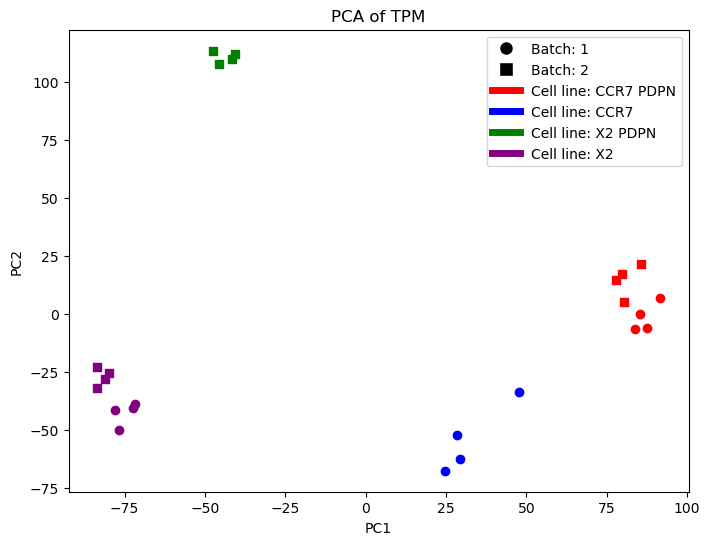

In [101]:
color_map = {'CCR7 PDPN': 'red', 'CCR7': 'blue', 'X2 PDPN': 'green','X2':"purple"}
marker_map = {'1': 'o', '2': 's'}

plt.figure(figsize=(8, 6))
texts = []

for i in range(len(pca_tpm)):
    genotype = pca_tpm_index.iloc[i]['Cell line']
    batch = pca_tpm_index.iloc[i]['Batch']
    
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=color_map[genotype], marker=marker_map[batch])
    #texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i]))

#adjust_text(texts)


legend_elements = [Line2D([0], [0], marker=marker_map[batch], color='w', label='Batch: ' + batch,
                          markerfacecolor='black', markersize=10) for batch in marker_map]
legend_elements += [Line2D([0], [0], color=color_map[genotype], lw=5, label='Cell line: ' + genotype) for genotype in color_map]

plt.legend(handles=legend_elements)
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## Merged datas

In [ ]:
scaled_tpm_me = scaler.fit_transform(tpm_me)

In [ ]:
pca = PCA(n_components=2) 
pca_result_me = pca.fit_transform(scaled_tpm_me)

In [ ]:
pca_tpm_me = pd.DataFrame(data=pca_result_me, columns=['PC1', 'PC2'])
pca_tpm_index_me=pca_tpm_me
pca_tpm_index_me.index = merged_df_1.index
pca_tpm_index_me["Genotype"]=metadata["Genotype"]
pca_tpm_index_me["Batch"]=metadata["Batch"]
pca_tpm_index_me["Batch"]= pca_tpm_index_me["Batch"].astype(str)

color_map = {'CPPP': 'red', 'CPPN': 'blue', 'CNPP': 'green','Ctrl':"purple"}
marker_map = {'1': 'o', '2': 's'}

plt.figure(figsize=(8, 6))
texts = []

for i in range(len(pca_tpm_me)):
    genotype = pca_tpm_index_me.iloc[i]['Genotype']
    batch = pca_tpm_index_me.iloc[i]['Batch']
    
    plt.scatter(pca_result_me[i, 0], pca_result_me[i, 1], color=color_map[genotype], marker=marker_map[batch])
    texts.append(plt.text(pca_result_me[i, 0], pca_result_me[i, 1], pca_tpm_index_me.index[i]))

adjust_text(texts)


legend_elements = [Line2D([0], [0], marker=marker_map[batch], color='w', label='Batch: ' + batch,
                          markerfacecolor='black', markersize=10) for batch in marker_map]
legend_elements += [Line2D([0], [0], color=color_map[genotype], lw=5, label='Genotype: ' + genotype) for genotype in color_map]

plt.legend(handles=legend_elements)
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# Data Preprocess - Check low counts

In [76]:
combo_df_4 = combo_df_1.copy()

In [77]:
column_sums = combo_df_4.sum()
combo_df_4.loc['sum'] = column_sums

In [78]:
combo_df_4

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000075268,ENSMUSG00000078528,ENSMUSG00000024810,ENSMUSG00000090369,ENSMUSG00000118217,ENSMUSG00000051984,ENSMUSG00000118210,ENSMUSG00000064344,ENSMUSG00000064357,ENSMUSG00000064372
X2_PDPN-_1,2484.0,1044.0,2810.0,21.0,54.0,2476.0,2275.0,18.0,820.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2_PDPN-_2,2021.0,991.0,2327.0,11.0,49.0,2004.0,1847.0,16.0,661.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2_PDPN-_3,2681.0,1151.0,2991.0,27.0,48.0,2647.0,2403.0,30.0,872.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2_PDPN-_4,2452.0,1244.0,3009.0,24.0,73.0,2583.0,2330.0,20.0,841.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN+_1,2418.0,1364.0,2810.0,14.0,109.0,2153.0,2369.0,21.0,870.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN+_2,2261.0,1329.0,2561.0,21.0,87.0,2027.0,2201.0,20.0,893.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN+_3,2180.0,1195.0,2509.0,20.0,109.0,1867.0,2073.0,7.0,846.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN+_4,2493.0,1243.0,2698.0,18.0,105.0,1941.0,2194.0,13.0,899.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN-_1,2862.0,1141.0,2770.0,26.0,86.0,2762.0,2215.0,21.0,907.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCR7_PDPN-_2,2452.0,1200.0,2887.0,17.0,60.0,2512.0,2287.0,17.0,882.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
low_count_columns = [column for column in  combo_df_4.columns if combo_df_4[column]['sum'] < 24]

if low_count_columns:
    for column in low_count_columns:
        print(column)
else:
    print("no low count")

no low count


# Multifactor analysis - merged_df_1

In [80]:
metadata = metadata.reindex(merged_df_1.index)

In [81]:
inference = DefaultInference(n_cpus=8)
dds_me = DeseqDataSet(
    counts=merged_df_1,
    metadata=metadata,
    design_factors=['Batch','Genotype'],
    refit_cooks=True,
    inference=inference,
)

In [82]:
dds_me.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.73 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 3.09 seconds.

Fitting LFCs...
... done in 1.50 seconds.

Refitting 0 outliers.



## Ctrl vs CPPN (ctrl vs pm)

In [ ]:
stat_res_Ctrl_vs_CPPN_me = DeseqStats(dds_me, contrast=["Genotype", "CPPN", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPN_me.summary()
#CCR7 PDPN- 相比较于 X2 PDPN- 

In [ ]:
stat_res_Ctrl_vs_CPPN_results_me = stat_res_Ctrl_vs_CPPN_me.results_df.copy()
stat_res_Ctrl_vs_CPPN_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CPPN_results_me.set_index('symbol',inplace = True)

In [ ]:
stat_res_Ctrl_vs_CPPN_results_me = stat_res_Ctrl_vs_CPPN_results_me.sort_values(by='padj', ascending=True)

In [ ]:
res_Ctrl_vs_CPPN_results_me=add_DEG_column(stat_res_Ctrl_vs_CPPN_me.results_df)

In [ ]:
res_Ctrl_vs_CPPN_results_me

In [ ]:
sns.histplot(mean_data, kde=True, stat="density", bins=0)
plt.xlabel("Mean values")
plt.ylabel("Density")
plt.title("Distribution of Mean Column")
plt.show()

### Valcano plot

In [ ]:
volcano_1(stat_res_Ctrl_vs_CPPN_results_me,(12,8))
plt.title('X2 PDPN- vs CCR7 PDPN-')
plt.show()

### DEG list

In [ ]:
not_significaiton_Ctrl_vs_CPPN_me = not_signification(stat_res_Ctrl_vs_CPPN_results_me)
not_significaiton_Ctrl_vs_CPPN_me

In [ ]:
filter_Ctrl_vs_CPPN_me = filter(stat_res_Ctrl_vs_CPPN_results_me)
filter_Ctrl_vs_CPPN_me

In [ ]:
up_Ctrl_vs_CPPN_me = up_reg(stat_res_Ctrl_vs_CPPN_results_me)
up_Ctrl_vs_CPPN_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = up_Ctrl_vs_CPPN_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
up_Ctrl_vs_CPPN_me.loc['Ccr7']

In [ ]:
up_Ctrl_vs_CPPN_me_s = up_reg_s(stat_res_Ctrl_vs_CPPN_results_me)
up_Ctrl_vs_CPPN_me_s

In [ ]:
down_Ctrl_vs_CPPN_me = down_reg(stat_res_Ctrl_vs_CPPN_results_me)
down_Ctrl_vs_CPPN_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = down_Ctrl_vs_CPPN_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
down_Ctrl_vs_CPPN_me_s = down_reg_s(stat_res_Ctrl_vs_CPPN_results_me)
down_Ctrl_vs_CPPN_me_s

In [ ]:
not_signification(stat_res_Ctrl_vs_CPPN_results_me)

### GSEA-result

In [ ]:
cppn_vs_ctrl = extract_and_save_columns('ctrl','Pm')

In [ ]:
cppn_vs_ctrl

In [ ]:
cppn_vs_ctrl.dtypes

In [ ]:
create_cls_file(cppn_vs_ctrl,'ctrl','Pm','cppn_vs_ctrl')

In [ ]:
enr_cppn_vs_ctrl, df_cppn_vs_ctrl = run_gsea_and_extract_results(cppn_vs_ctrl,'cppn_vs_ctrl','ctrl','Pm')

In [ ]:
df_cppn_vs_ctrl

In [ ]:
from gseapy import dotplot
ax_1 = dotplot(enr_cppn_vs_ctrl.res2d,
             column="FDR q-val",
             ofname = None,
             title = 'CCR7 PDPN- vs X2 PDPN-',
             cmap=plt.cm.viridis,
             size=4,legend_size = 1,
             figsize=(4,5), cutoff=1)

In [ ]:
df_cppn_vs_ctrl

### MsigDb Hallmark

In [ ]:
hallmark_enrichment(up_Ctrl_vs_CPPN_me)

In [ ]:
hallmark_enrichment(down_Ctrl_vs_CPPN_me)

## Ctrl vs CNPP (ctrl vs x2 pp)

In [ ]:
stat_res_Ctrl_vs_CNPP_me = DeseqStats(dds_me, contrast=["Genotype", "CNPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CNPP_me.summary()
#X2 PDPN+ 相比较于 X2 PDPN-

In [ ]:
stat_res_Ctrl_vs_CNPP_results_me = stat_res_Ctrl_vs_CNPP_me.results_df.copy()
stat_res_Ctrl_vs_CNPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CNPP_results_me.set_index('symbol',inplace = True)

In [ ]:
res_Ctrl_vs_CNPP_results_me = add_DEG_column(stat_res_Ctrl_vs_CNPP_me.results_df)

In [ ]:
res_Ctrl_vs_CNPP_results_me

### Valcano plot

In [ ]:
volcano_1(stat_res_Ctrl_vs_CNPP_results_me,(12,8))
plt.title('ctrl_vs_x2pp')

### DEG list

In [ ]:
not_significaiton_Ctrl_vs_CNPP_me = not_signification(stat_res_Ctrl_vs_CNPP_results_me)
not_significaiton_Ctrl_vs_CNPP_me

In [ ]:
filter_Ctrl_vs_CNPP_me = filter(stat_res_Ctrl_vs_CNPP_results_me)
filter_Ctrl_vs_CNPP_me

In [ ]:
up_Ctrl_vs_CNPP_me = up_reg(stat_res_Ctrl_vs_CNPP_results_me)
up_Ctrl_vs_CNPP_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = up_Ctrl_vs_CNPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
up_Ctrl_vs_CNPP_me_s = up_reg_s(stat_res_Ctrl_vs_CNPP_results_me)
up_Ctrl_vs_CNPP_me_s

In [ ]:
down_Ctrl_vs_CNPP_me = down_reg(stat_res_Ctrl_vs_CNPP_results_me)
down_Ctrl_vs_CNPP_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = down_Ctrl_vs_CNPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
down_Ctrl_vs_CNPP_me_s = down_reg_s(stat_res_Ctrl_vs_CNPP_results_me)
down_Ctrl_vs_CNPP_me_s

### GSEA-result

In [ ]:
x2pp_vs_ctrl = extract_and_save_columns('ctrl','X2_Pp')

In [ ]:
create_cls_file(x2pp_vs_ctrl,'ctrl','X2_Pp','x2pp_vs_ctrl.cls')

In [ ]:
enr_x2pp_vs_ctrl,df_x2pp_vs_ctrl = run_gsea_and_extract_results(x2pp_vs_ctrl,'x2pp_vs_ctrl.cls','ctrl','X2_Pp')

In [ ]:
ax_2 = dotplot(enr_x2pp_vs_ctrl.res2d[:3],
             column="FDR q-val",
             ofname = None,
             title = 'X2 PDPN vs X2 ',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5.5), cutoff=1)

In [ ]:
df_x2pp_vs_ctrl

### MsigDb Hallmark

In [ ]:
hallmark_enrichment(up_Ctrl_vs_CNPP_me)

In [ ]:
hallmark_enrichment(down_Ctrl_vs_CNPP_me)

## Ctrl vs CPPP (ctrl vs pp)

In [ ]:
stat_res_Ctrl_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPP_me.summary()
# CCR7 PDPN+ 相比较于 X2 PDPN-

In [ ]:
stat_res_Ctrl_vs_CPPP_results_me = stat_res_Ctrl_vs_CPPP_me.results_df.copy()
stat_res_Ctrl_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [ ]:
res_Ctrl_vs_CPPP_results_me = add_DEG_column(stat_res_Ctrl_vs_CPPP_me.results_df)

In [ ]:
res_Ctrl_vs_CPPP_results_me

### Valcano plot

In [ ]:
volcano_1(stat_res_Ctrl_vs_CPPP_results_me,(12,8))
plt.title('ctrl_vs_pp')
plt.show()

### DEG list

In [ ]:
not_significaiton_Ctrl_vs_CPPP_me = not_signification(stat_res_Ctrl_vs_CPPP_results_me)
not_significaiton_Ctrl_vs_CPPP_me

In [ ]:
filter_Ctrl_vs_CPPP_me = filter(stat_res_Ctrl_vs_CPPP_results_me)
filter_Ctrl_vs_CPPP_me

In [ ]:
up_Ctrl_vs_CPPP_me = up_reg(stat_res_Ctrl_vs_CPPP_results_me)
up_Ctrl_vs_CPPP_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = up_Ctrl_vs_CPPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
up_Ctrl_vs_CPPP_me_s = up_reg_s(stat_res_Ctrl_vs_CPPP_results_me)
up_Ctrl_vs_CPPP_me_s

In [ ]:
down_Ctrl_vs_CPPP_me = down_reg(stat_res_Ctrl_vs_CPPP_results_me)
down_Ctrl_vs_CPPP_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = down_Ctrl_vs_CPPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
down_Ctrl_vs_CPPP_me_s = down_reg_s(stat_res_Ctrl_vs_CPPP_results_me)
down_Ctrl_vs_CPPP_me_s

### GSEA-result

In [ ]:
pp_vs_ctrl = extract_and_save_columns('ctrl','Pp')

In [ ]:
create_cls_file(pp_vs_ctrl,'ctrl','Pp','pp_vs_ctrl.cls')

In [ ]:
create_cls_file_1(pp_vs_ctrl,'ctrl','Pp','pp_vs_ctrl_1.cls')

In [ ]:
enr_pp_vs_ctrl,df_pp_vs_ctrl=run_gsea_and_extract_results(pp_vs_ctrl,'pp_vs_ctrl.cls','ctrl','Pp')

enr_pp_vs_ctrl_1,df_pp_vs_ctrl_1=run_gsea_and_extract_results(pp_vs_ctrl,'pp_vs_ctrl_1.cls','ctrl','Pp')

In [ ]:
ax_3 = dotplot(enr_pp_vs_ctrl.res2d,
             column="FDR q-val",
             ofname = None,
             title = 'CCR7 PDPN+ vs X2 PDPN-',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

ax_3_1 = dotplot(enr_pp_vs_ctrl_1.res2d,
             column="FDR q-val",
             ofname = None,
             title = 'CCR7 PDPN+ vs X2 PDPN-',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

In [ ]:
df_pp_vs_ctrl

### MsigDb Hallmark

In [ ]:
hallmark_enrichment(up_Ctrl_vs_CPPP_me)

In [ ]:
hallmark_enrichment(down_Ctrl_vs_CPPP_me)

## CPPN vs CPPP (pm vs pp)

In [83]:
stat_res_CPPN_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "CPPN"], inference=inference)
stat_res_CPPN_vs_CPPP_me.summary()
# CCR7 PDPN+ 相比较于 CCR7 PDPN-

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs CPPN
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl                                                                         
ENSMUSG00000033845  2370.355943       -0.169719  0.036013 -4.712659  0.000002   
ENSMUSG00000025903  1159.267411        0.090001  0.051736  1.739623  0.081925   
ENSMUSG00000033813  2662.413556       -0.212615  0.052043 -4.085404  0.000044   
ENSMUSG00000062588    20.080322        0.052061  0.284011  0.183306  0.854558   
ENSMUSG00000002459    69.834088        0.388486  0.142555  2.725158  0.006427   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000051412   783.762879       -0.013702  0.057291 -0.239158  0.810983   
ENSMUSG00000061654   558.076836        0.143298  0.060238  2.378880  0.017365   
ENSMUSG00000079834   671.147121        0.104747  0.052040  2.012839  0.044132   
ENSMUSG00000095041  5672.196591        0.349189  

... done in 0.85 seconds.



In [84]:
stat_res_CPPN_vs_CPPP_results_me = stat_res_CPPN_vs_CPPP_me.results_df.copy()
stat_res_CPPN_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CPPN_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [85]:
stat_res_CPPN_vs_CPPP_results_me = stat_res_CPPN_vs_CPPP_results_me.sort_values(by='padj', ascending=True)

In [86]:
res_CPPN_vs_CPPP_results_me = add_DEG_column(stat_res_CPPN_vs_CPPP_me.results_df)

### Valcano plot

/var/folders/_j/kjc1l0v12mg93vxbnw2f1pq80000gn/T/ipykernel_3000/2293352598.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Not significant",color = 'grey',alpha=0.35,edgecolor='none')
/var/folders/_j/kjc1l0v12mg93vxbnw2f1pq80000gn/T/ipykernel_3000/2293352598.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Down-regulated",color="teal",alpha=0.55,edgecolor='none')


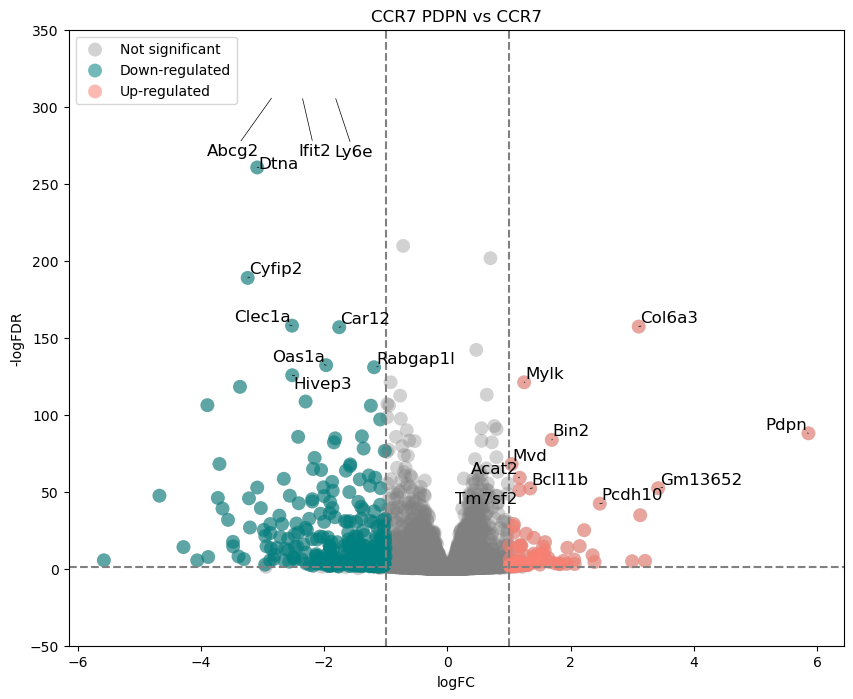

In [87]:
volcano_1(stat_res_CPPN_vs_CPPP_results_me,(10,8))
plt.title('CCR7 PDPN vs CCR7')
plt.show()

### DEG list

In [ ]:
filter_CPPPvsCPPN_me = filter(stat_res_CPPN_vs_CPPP_results_me)
filter_CPPPvsCPPN_me

In [ ]:
up_CPPPvsCPPN_me = up_reg(stat_res_CPPN_vs_CPPP_results_me)
up_CPPPvsCPPN_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = up_CPPPvsCPPN_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
up_CPPPvsCPPN_me_s = up_reg_s(stat_res_CPPN_vs_CPPP_results_me)
up_CPPPvsCPPN_me_s

In [ ]:
save(up_CPPPvsCPPN_me,'Up_CPPPvsCPPN_me')

In [ ]:
down_CPPPvsCPPN_me = down_reg(stat_res_CPPN_vs_CPPP_results_me)
down_CPPPvsCPPN_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = down_CPPPvsCPPN_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
down_CPPPvsCPPN_me_s = down_reg_s(stat_res_CPPN_vs_CPPP_results_me)
down_CPPPvsCPPN_me_s

In [ ]:
not_significaiton_CPPP_vs_CPPN_me = not_signification(stat_res_CPPN_vs_CPPP_results_me)

### GSEA-result

In [180]:
pp_vs_pm =extract_and_save_columns('Pm','Pp')

In [181]:
pp_vs_pm

,Pp_1,Pp_2,Pp_3,Pp_4,Pm_1,Pm_2,Pm_3,Pm_4,Pp_1_1,Pp_2_1,Pp_3_1,Pp_4_1
symbol_1,,,,,,,,,,,,
Mrpl15,2418.0,2261.0,2180.0,2493.0,2862.0,2452.0,2959.0,1874.0,1833.0,2386.0,2403.0,2182.0
Lypla1,1364.0,1329.0,1195.0,1243.0,1141.0,1200.0,1338.0,918.0,938.0,1369.0,1352.0,1229.0
Tcea1,2810.0,2561.0,2509.0,2698.0,2770.0,2887.0,3617.0,2366.0,1852.0,2580.0,2659.0,2304.0
Rgs20,109.0,87.0,109.0,105.0,86.0,60.0,77.0,79.0,62.0,93.0,108.0,79.0
Atp6v1h,2153.0,2027.0,1867.0,1941.0,2762.0,2512.0,3141.0,1963.0,1579.0,2060.0,2295.0,1960.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Il33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,7.0,12.0,7.0
4933411K16Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,7.0
Gm6951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,13.0,16.0,8.0


In [182]:


create_cls_file_1(pp_vs_pm,'Pm','Pp','pp_vs_pm')

pp_vs_pm has been created successfully.
12 2 1
# Pm Pp
1 1 1 1 0 0 0 0 1 1 1 1


In [183]:
enr_pp_vs_pm,df_pp_vs_pm = run_gsea_and_extract_results_1(pp_vs_pm,'pp_vs_pm.cls')

2025-01-06 14:57:04,987 [WARNING] Input data contains NA, filled NA with 0
2025-01-06 14:57:04,993 [WARNING] Found duplicated gene names, values averaged by gene names!


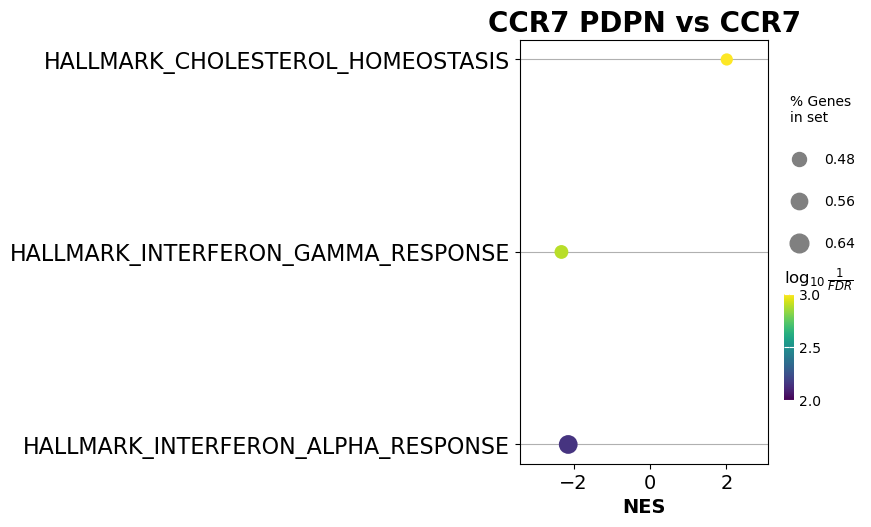

In [203]:
ax_4 = dotplot(enr_pp_vs_pm.res2d[:3],
             column="FDR q-val",
             ofname = None,
             title ='CCR7 PDPN vs CCR7',
             cmap=plt.cm.viridis,
             size=3.5,
             figsize=(4,5.5), cutoff=1)

In [189]:
df_pp_vs_pm

,Term,fdr,es,nes
0,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.000725,0.610433,2.008162
1,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.001282,-0.650007,-2.320799
2,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.007051,-0.703079,-2.142721


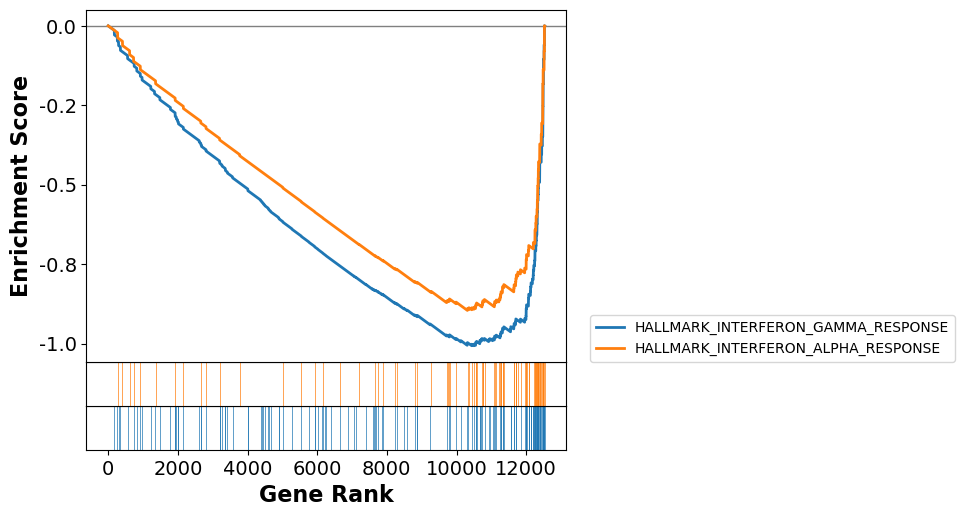

In [186]:
terms = enr_pp_vs_pm.res2d.Term
axs = enr_pp_vs_pm.plot(terms[:2], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

### MsigDb Hallmark

In [ ]:
hallmark_enrichment(up_CPPPvsCPPN_me)

In [ ]:
hallmark_enrichment(down_CPPPvsCPPN_me)

## CNPP vs CPPP (x2pp vs pp)

In [ ]:
stat_res_CNPP_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "CNPP"], inference=inference)
stat_res_CNPP_vs_CPPP_me.summary()
# CCR7 PDPN+ 相比较于 X2 PDPN+

In [ ]:
stat_res_CNPP_vs_CPPP_results_me = stat_res_CNPP_vs_CPPP_me.results_df.copy()
stat_res_CNPP_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CNPP_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [ ]:
stat_res_CNPP_vs_CPPP_results_me = stat_res_CNPP_vs_CPPP_results_me.sort_values(by='padj', ascending=True)

In [ ]:
res_CNPP_vs_CPPP_results_me = add_DEG_column(stat_res_CNPP_vs_CPPP_me.results_df)

### Valcano plot

In [ ]:
volcano_1(stat_res_CNPP_vs_CPPP_results_me,(10,8))
plt.title('x2pp_vs_pp')

### DEG list

In [ ]:
filter_CNPPvsCPPP_me= filter(stat_res_CNPP_vs_CPPP_results_me)
filter_CNPPvsCPPP_me

In [ ]:
up_CPPPvsCNPP_me = up_reg(stat_res_CNPP_vs_CPPP_results_me)
up_CPPPvsCNPP_me

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = up_CPPPvsCNPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)

symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
save(up_CPPPvsCNPP_me,'Up_CPPPvsCNPP_me')

In [ ]:
down_CPPPvsCNPP_me = down_reg(stat_res_CNPP_vs_CPPP_results_me)
down_CPPPvsCNPP_me.head(99)

In [ ]:
# 假设 df 是你的 DataFrame
symbol_list = down_CPPPvsCNPP_me.index[:100].tolist()  # 提取前 100 个索引并转换为列表

# 打印完整的列表
print(symbol_list)


In [ ]:
symbol_df = pd.DataFrame(symbol_list, columns=['Symbol'])

# 导出为 Excel 文件
symbol_df.to_excel('symbol_list.xlsx', index=False)

print("List 已成功导出为 'symbol_list.xlsx'")

In [ ]:
not_significaiton_CPPP_vs_CNPP_me = not_signification(stat_res_CNPP_vs_CPPP_results_me)

### gsea-result

In [ ]:
pp_vs_x2pp=extract_and_save_columns('Pp','X2_Pp')

In [ ]:
create_cls_file_1(pp_vs_x2pp,'X2_Pp','Pp','pp_vs_x2pp.cls')

In [ ]:
enr_pp_vs_x2pp,df_pp_vs_x2pp = run_gsea_and_extract_results_1(pp_vs_x2pp,'pp_vs_x2pp.cls')

In [ ]:
ax_5 = dotplot(enr_pp_vs_x2pp.res2d,
             column="FDR q-val",
             ofname = None,
             title = 'CCR7 PDPN+ vs X2 PDPN+',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

In [ ]:
df_pp_vs_x2pp

### MsigDb Hallmark

In [ ]:
hallmark_enrichment(down_CPPPvsCNPP_me)

In [ ]:
hallmark_enrichment(up_CPPPvsCNPP_me)

## CNPP _vs_ CPPN x2pp vs pm

In [247]:
#这玩意到底有什么比较意义

In [248]:
stat_res_CNPP_vs_CPPN_me = DeseqStats(dds_me, contrast=["Genotype", "CPPN", "CNPP"], inference=inference)
#CPPN 相较于 CNPP

In [249]:
stat_res_CNPP_vs_CPPN_me.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPN vs CNPP
                       baseMean  log2FoldChange     lfcSE       stat  \
ensembl                                                                
ENSMUSG00000033845  2370.355943        0.220269  0.047264   4.660356   
ENSMUSG00000025903  1159.267411        0.271240  0.068269   3.973107   
ENSMUSG00000033813  2662.413556        0.231889  0.068260   3.397117   
ENSMUSG00000062588    20.080322        0.276960  0.371700   0.745117   
ENSMUSG00000002459    69.834088        0.449368  0.200180   2.244823   
...                         ...             ...       ...        ...   
ENSMUSG00000051412   783.762879        0.249751  0.075837   3.293280   
ENSMUSG00000061654   558.076836       -0.920334  0.074114 -12.417900   
ENSMUSG00000079834   671.147121       -0.080038  0.067874  -1.179199   
ENSMUSG00000095041  5672.196591       -0.704970  0.135427  -5.205536   
ENSMUSG00000063897   537.012771        0.358158  0.077437   4.625131   

   

... done in 0.97 seconds.



In [250]:
stat_res_CNPP_vs_CPPN_results_me = stat_res_CNPP_vs_CPPN_me.results_df.copy()
stat_res_CNPP_vs_CPPN_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CNPP_vs_CPPN_results_me.set_index('symbol',inplace = True)

In [251]:
stat_res_CNPP_vs_CPPN_results_me = stat_res_CNPP_vs_CPPN_results_me.sort_values(by='padj', ascending=True)

In [252]:
res_CNPP_vs_CPPN_results_me = add_DEG_column(stat_res_CNPP_vs_CPPN_me.results_df)

In [ ]:
res_CNPP_vs_CPPN_results_me

### Valcano plot

In [ ]:
volcano_1(stat_res_CNPP_vs_CPPN_results_me,(10,8))
plt.title('x2pp_vs_pm')

### DEG list

In [ ]:
filter_CNPPvsCPPN_me= filter(stat_res_CNPP_vs_CPPN_results_me)
filter_CNPPvsCPPN_me

In [ ]:
up_CNPPvsCPPN_me = up_reg(stat_res_CNPP_vs_CPPN_results_me)
up_CNPPvsCPPN_me

In [ ]:
down_CNPPvsCPPN_me = down_reg(stat_res_CNPP_vs_CPPN_results_me)
down_CNPPvsCPPN_me

### gsea-result

In [ ]:
x2pp_vs_pm=extract_and_save_columns('X2_','Pm')

In [ ]:
create_cls_file(x2pp_vs_pm,'X2_Pp','Pm','x2pp_vs_pm.cls')

In [ ]:
enr_x2pp_vs_pm,df_x2pp_vs_pm=run_gsea_and_extract_results(x2pp_vs_pm,'x2pp_vs_pm.cls','X2_Pp','Pm')

In [ ]:
df_x2pp_vs_pm

### MgsigDb Hallmark

In [ ]:
hallmark_enrichment(down_CNPPvsCPPN_me)

In [ ]:
hallmark_enrichment(up_CNPPvsCPPN_me)

# Gene Dependency Analysis

## PDPN Dependent Genes

In [ ]:
up_pdpn = pd.merge(up_Ctrl_vs_CNPP_me, up_CPPPvsCPPN_me, left_index=True, right_index=True, how='inner')

In [ ]:
#up_ccr7

In [ ]:
hallmark_enrichment(up_pdpn)

In [ ]:
down_pdpn = pd.merge(down_Ctrl_vs_CNPP_me, down_CPPPvsCPPN_me, left_index=True, right_index=True, how='inner')

In [ ]:
hallmark_enrichment(down_pdpn)

In [ ]:
#(DEG in (ctrlvspp) & DEG(ctrlvspm) & Notsignification(ctrlvsx2pp)& DEG(x2ppvspp) & Notsignification(pmvspp)

In [ ]:
index_intersection_cp_1 = filter_Ctrl_vs_CPPN_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(not_significaiton_Ctrl_vs_CNPP_me.index).intersection(filter_CNPPvsCPPP_me.index).intersection(not_significaiton_CPPP_vs_CPPN_me.index)

In [ ]:
DEG_cp_1 = filter_Ctrl_vs_CPPN_me.loc[index_intersection_cp_1]

In [ ]:
DEG_cp_1 = DEG_cp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_cp_1

In [ ]:
save(DEG_cp_1,'ccr7_dependent_gene_list_1')

In [ ]:
hallmark_enrichment(DEG_cp_1)

In [ ]:
up(DEG_cp_1)

In [ ]:
down(DEG_cp_1)

In [ ]:
# DEG(ctrlvspp)& DEG(x2ppvspp)&DEG(ctrlvspm)

In [ ]:
index_intersection_cp_2 = filter_Ctrl_vs_CPPP_me.index.intersection(filter_CNPPvsCPPP_me.index).intersection(filter_Ctrl_vs_CPPN_me.index)

In [ ]:
DEG_cp_2 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_cp_2]

In [ ]:
DEG_cp_2 = DEG_cp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_cp_2

In [ ]:
save(DEG_cp_2,'ccr7_dependent_gene_list_2')

In [ ]:
hallmark_enrichment(DEG_cp_2)

In [ ]:
up(DEG_cp_2)

In [ ]:
down(DEG_cp_2)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
gsea(DEG_cp_2)

## CCR7 Dependent Genes 

In [ ]:
up_CCR7 = pd.merge(up_Ctrl_vs_CPPN_me, up_Ctrl_vs_CNPP_me, left_index=True, right_index=True, how='inner')

In [ ]:
hallmark_enrichment(up_CCR7)

In [ ]:
down_ccr7= pd.merge(down_Ctrl_vs_CPPN_me, down_Ctrl_vs_CNPP_me, left_index=True, right_index=True, how='inner')

In [ ]:
hallmark_enrichment(down_ccr7)

In [ ]:
#(DEG in (ctrlvspp) & DEG(ctrlvsx2pp) & DEG(ppvspm))

In [ ]:
index_intersection_pp_1 = filter_Ctrl_vs_CNPP_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(filter_CPPPvsCPPN_me.index)

In [ ]:
DEG_pp_1 = filter_Ctrl_vs_CNPP_me.loc[index_intersection_pp_1]

In [ ]:
DEG_pp_1 = DEG_pp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_pp_1

In [ ]:
hallmark_enrichment(DEG_pp_1)

In [ ]:
save(DEG_pp_1,'pdpn_dependent_gene_list_1')

In [ ]:
up(DEG_pp_1)

In [ ]:
down(DEG_pp_1)

gsea(DEG_pp_1) #too less genes 

In [ ]:
# DEG(ctrlvspp)& DEG(x2ppvspp)&Notsignificaiton(ctrlvspm)

index_intersection_pp_2 = filter_Ctrl_vs_CNPP_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(not_significaiton_Ctrl_vs_CPPN_me.index)

DEG_pp_2 = filter_Ctrl_vs_CNPP_me.loc[index_intersection_pp_2]

DEG_pp_2 = DEG_pp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_pp_2

hallmark_enrichment(DEG_pp_2)

## CCR7&PDPN Dependent Genes

In [ ]:
#(DEG in (ctrlvspp) & Notsignification(ctrlvsx2pp) & Notsignification(ctrlvspm)& DEG in (pmvspp)& DEG in (x2ppvspp)

In [ ]:
index_intersection_dp_1 = filter_Ctrl_vs_CPPP_me.index.intersection(not_significaiton_Ctrl_vs_CPPN_me.index).intersection(not_significaiton_Ctrl_vs_CNPP_me.index).intersection(filter_CNPPvsCPPP_me.index).intersection(filter_CPPPvsCPPN_me.index)

In [ ]:
DEG_dp_1 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_dp_1]

In [ ]:
DEG_dp_1 = DEG_dp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_dp_1

In [ ]:
save(DEG_dp_1,'ccr7_pdpn_dependent_gene_list_1')

In [ ]:
hallmark_enrichment(DEG_dp_1)

In [ ]:
down(DEG_dp_1)

In [ ]:
up(DEG_dp_1)

gsea(DEG_dp_1) # gene list is too short

In [ ]:
## DEG(ctrlvspp)&Notsignificaiton(pmvspp)&Notsignificaiton(x2ppvspp)

index_intersection_dp_2 = filter_Ctrl_vs_CPPP_me.index.intersection(not_significaiton_CPPP_vs_CNPP_me.index).intersection(not_significaiton_CPPP_vs_CPPN_me.index)

DEG_dp_2 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_dp_2]

DEG_dp_2 = DEG_dp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_dp_2

hallmark_enrichment(DEG_dp_2)

## Cooperative

In [ ]:
# Down(ctrlvspp)& Down(ctrlvspm)& Down (ctrlvsx2pp) log2FC of down(ctrlvspp) min
# Up(ctrlvspp)& Up(ctrlvspm)& up(ctrlvsx2pp) log2FC of up(ctrlvspp) max

### Down

In [ ]:
index_intersection_down_1 = down_Ctrl_vs_CPPP_me.index.intersection(down_Ctrl_vs_CPPN_me.index).intersection(down_Ctrl_vs_CNPP_me.index)

In [ ]:
DEG_down_1 = pd.DataFrame()

In [ ]:
for idx in index_intersection_down_1:
    if down_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'] == min(down_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'], down_Ctrl_vs_CPPN_me.loc[idx, 'log2FoldChange'], down_Ctrl_vs_CNPP_me.loc[idx, 'log2FoldChange']):
        row_to_append = down_Ctrl_vs_CPPP_me.loc[idx:idx]
        DEG_down_1 = pd.concat([DEG_down_1, row_to_append], ignore_index=False)

In [ ]:
DEG_down_1

In [ ]:
save(DEG_down_1,'cooperative_down')

In [ ]:
hallmark_enrichment(DEG_down_1)

### Up

In [ ]:
index_intersection_up_1 = up_Ctrl_vs_CPPP_me.index.intersection(up_Ctrl_vs_CPPN_me.index).intersection(up_Ctrl_vs_CNPP_me.index)

In [ ]:
DEG_up_1 = pd.DataFrame()

In [ ]:
for idx in index_intersection_up_1:
    if up_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'] == max(up_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'], up_Ctrl_vs_CPPN_me.loc[idx, 'log2FoldChange'], up_Ctrl_vs_CNPP_me.loc[idx, 'log2FoldChange']):
        row_to_append = up_Ctrl_vs_CPPP_me.loc[idx:idx]
        DEG_up_1 = pd.concat([DEG_up_1, row_to_append], ignore_index=False)

In [ ]:
DEG_up_1

In [ ]:
save(DEG_up_1,'cooperative_up')

In [ ]:
hallmark_enrichment(DEG_up_1)

# Heatmap

In [161]:
order_req = ['X2_PDPN-_2','X2_PDPN-_3','X2_PDPN-_1','X2_PDPN-_6','X2_PDPN-_8','X2_PDPN-_7','X2_PDPN-_5','X2_PDPN-_4','CCR7_PDPN-_1','CCR7_PDPN-_3','CCR7_PDPN-_2','CCR7_PDPN-_4',
            'X2_PDPN+_2','X2_PDPN+_4','X2_PDPN+_1','X2_PDPN+_3','CCR7_PDPN+_8','CCR7_PDPN+_4','CCR7_PDPN+_1','CCR7_PDPN+_7','CCR7_PDPN+_3','CCR7_PDPN+_2','CCR7_PDPN+_5','CCR7_PDPN+_6']

In [162]:
dds_me.layers['log1p']=np.log1p(dds_me.layers['normed_counts'])

## Interferon gamma and alpha

In [224]:
order_fol = ['Il7','Oas2','Cd274','Gbp3','Xaf1','Parp14','Ifih1','Rtp4','Ifi44','Usp18','Rsad2',
            'Oasl2','Irf7','Oas1a','Oas3','Ifit2','C1s1','H2-D1','H2-K1','Ccr7','Pdpn']

In [164]:
#heatmap_real(GOIs_IFN, 'Interferon genes')

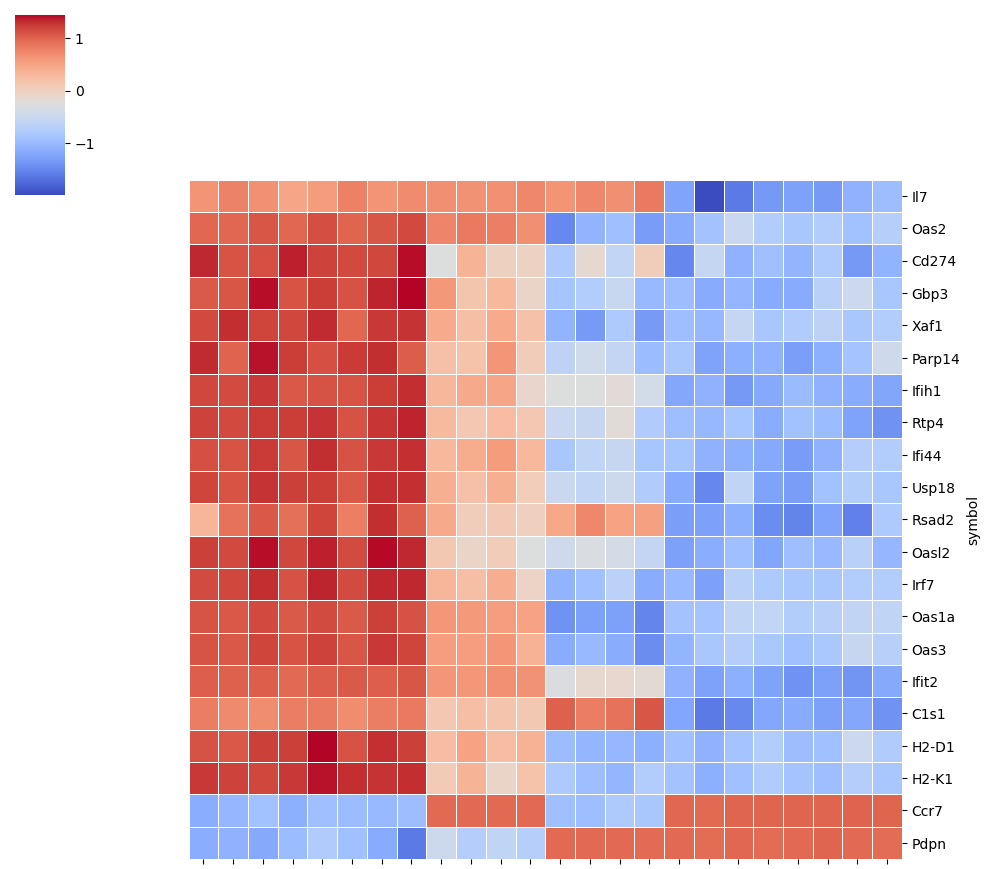

In [226]:
heatmap_3(order_fol,'interferon_genes')

## MHC I

https://www.informatics.jax.org/marker/MGI:95896
https://www.informatics.jax.org/marker/MGI:95915
https://www.informatics.jax.org/marker/MGI:95942
https://www.informatics.jax.org/marker/MGI:95956
https://www.informatics.jax.org/marker/MGI:95904

In [166]:
mhc1 = ['Ccr7','Pdpn','H2-K1','H2-D1','H2-T10','H2-M3']

In [167]:
# H2-T10 raw count under 25

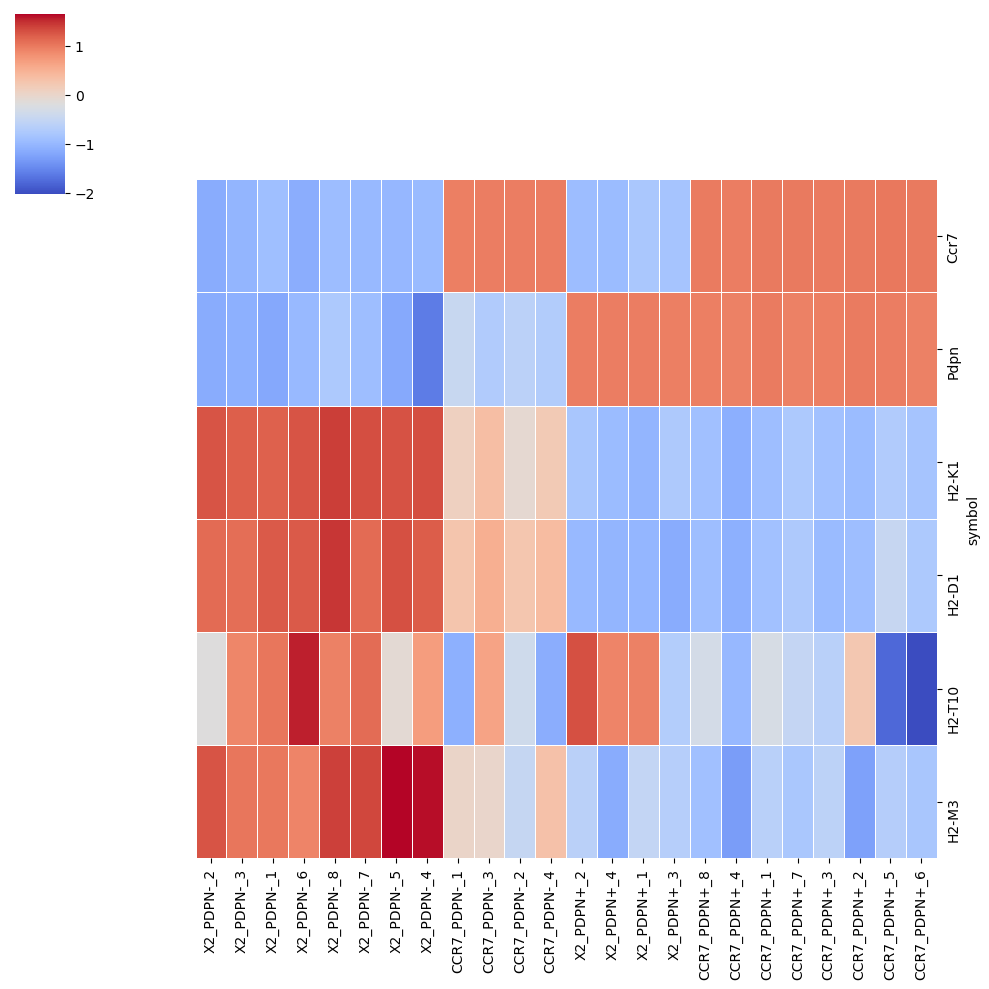

In [168]:
heatmap(mhc1,'mhci genes')

## Receptors

In [169]:
receptors = ['Erbb3','Esr1','Pgrmc1','Zeb1','Zeb2','Pgrmc2','Erbb2','Vim','Wnt7b','Twist1','Krt8','Ccr7','Pdpn']

In [170]:
# erbb2 raw count is pretty high
# pgrmc2 raw count is pretty high

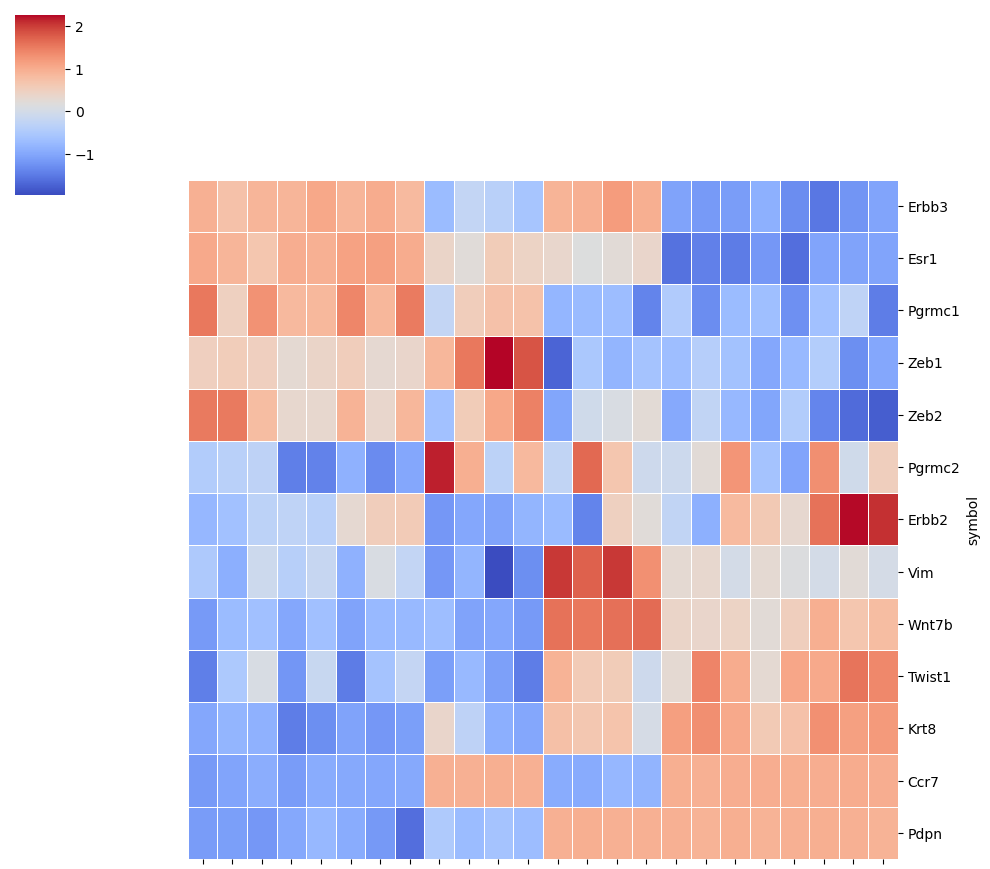

In [171]:
heatmap_3(receptors,'receptor genes')

## Dotplot

heatmap_IFN_renamed = heatmap_IFN.copy()
heatmap_IFN_renamed = heatmap_IFN_renamed.stack().reset_index()  
heatmap_IFN_renamed.columns = ['Gene', 'Sample_name', 'Expression']  

heatmap_IFN_renamed

import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "red"])

min_expr = heatmap_IFN_renamed['Expression'].min()
max_expr = heatmap_IFN_renamed['Expression'].max()

fig, ax = plt.subplots(figsize=(12, 10))
dotpot=sns.scatterplot(data=heatmap_IFN_renamed, x='Sample_name', y='Gene', size='Expression', sizes=(10,240),hue='Expression',alpha=0.68,
                      palette=cmap, edgecolor="black",hue_norm=(min_expr, max_expr))
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
fig.savefig('dotpot_IFN.png', transparent=True)

In [99]:
## GOIs

In [ ]:
GOIs = ['Esr1','Erbb3','Pgrmc1','Ccr7','Pdpn']

In [ ]:
heatmap(GOIs)

## EMT marker

In [ ]:
EMT_sets = []
with open('/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.v2023.2.Mm.gmt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')  
        genes = parts[0:]  
        EMT_sets.extend(genes)

In [ ]:
heatmap_full(EMT_sets)

## Collagens only

In [ ]:
def heatmap_real_1(gene_list, file_name):
    results = []
    
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:, GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)
    
    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    # 绘制聚类热图（无色彩条）
    hm = sns.clustermap(heatmap_data, cmap="coolwarm", col_cluster=False, row_cluster=False,
                        linewidths=0.5, linecolor='white', z_score=0, yticklabels=True, mask=False)
    
    hm.ax_heatmap.set_xticklabels([])  # 移除默认的X轴标签
    
    # 添加文字标签到X轴
    for tick_label in heatmap_data.columns:
        if tick_label.startswith('X2_PDPN-'):
            label = 'X2_PDPN-'
        elif tick_label.startswith('X2_PDPN+'):
            label = 'X2_PDPN+'
        else:
            label = ''  # 如果匹配不上，保持空白
        
        # 在热图底部添加文字
        hm.ax_heatmap.text(heatmap_data.columns.get_loc(tick_label) + 0.5, 
                           -0.5, 
                           label, 
                           ha='center', 
                           va='center', 
                           fontsize=8, 
                           rotation=90)
    
    # 保存热图
    hm.savefig(f"{file_name}.png", dpi=300)
    
    plt.show()
    return hm


In [196]:
def heatmap_collagen(gene_list):
    results = []
    for gene in gene_list:
        indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
        for index in indices:
            results.append({'Symbol': gene, 'Index': index})
    GOI_df = pd.DataFrame(results)
    GOI_df = GOI_df.set_index('Index')
    
    dds_GOI = dds_me[:,GOI_df.index]
    heatmap_data = pd.DataFrame(dds_GOI.layers['log1p'].T,
                                index=dds_GOI.var_names, columns=dds_GOI.obs_names)

    heatmap_data = heatmap_data[order_req]
    heatmap_data['symbol'] = combo_df_2['symbol_1']
    heatmap_data.set_index('symbol', inplace=True)

    hm = sns.clustermap(heatmap_data,col_cluster=False, cmap="coolwarm",row_cluster=False,linewidths=0.5, linecolor='black',yticklabels=True,mask=False)


    hm.ax_heatmap.set_xticklabels([])
   
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()
    return hm

In [180]:
collagens = ['Esr1','Erbb3','Col5a1','Col6a1','Col6a2','Col16a1','Col4a2','Col6a3','Ccr7','Pdpn']

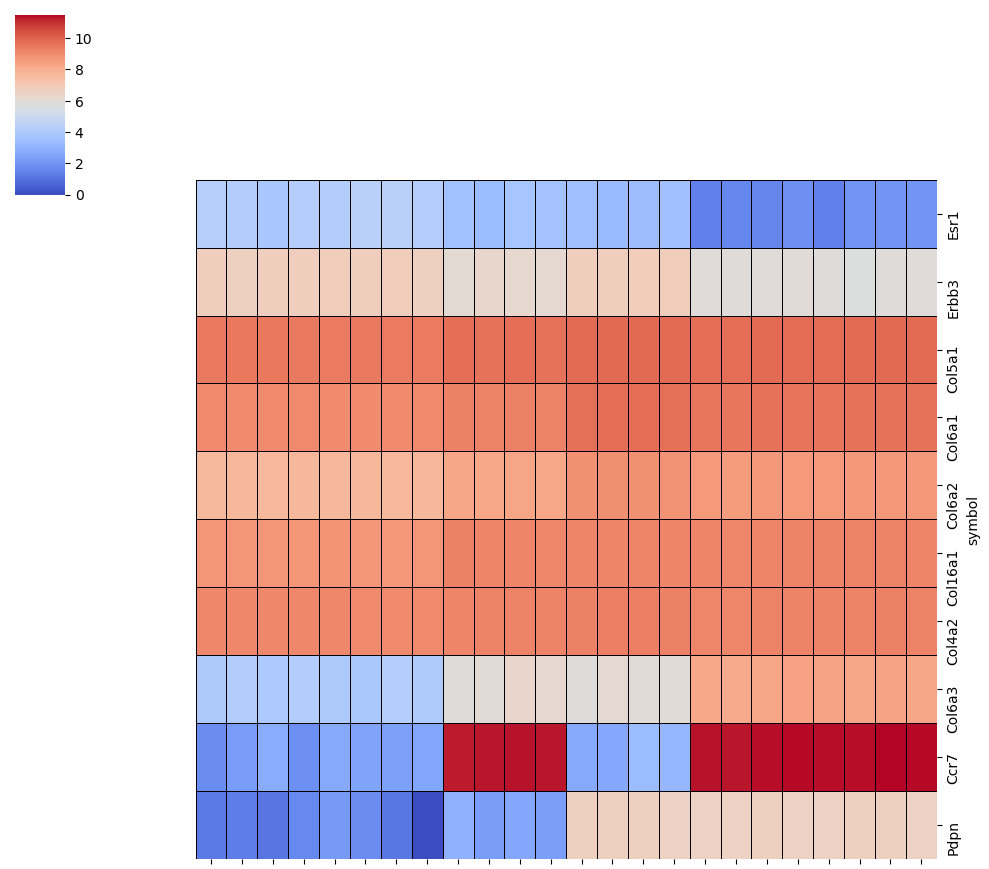

In [197]:
heatmap_collagen(collagens)

In [182]:
indice_col_all = [str(col) for col in combo_df_2['symbol_1'] if str(col).startswith('Col')]

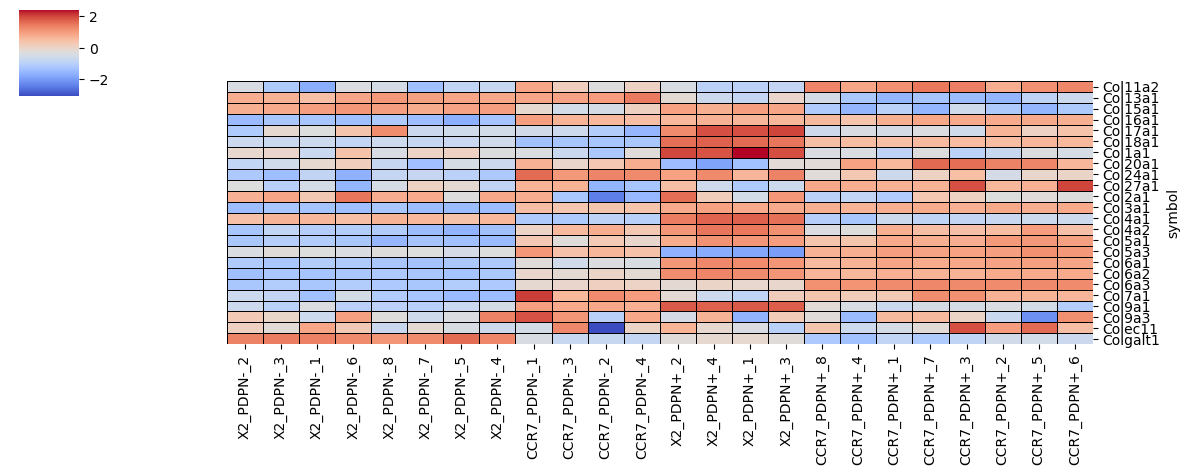

In [183]:
heatmap_full(indice_col_all)

In [184]:
element_remove = ['Colec11','Col24a1','Col2a1','Col9a3']
# 跟ECM没关系的

In [185]:
relate_collagen = [item for item in indice_col_all if item not in element_remove]

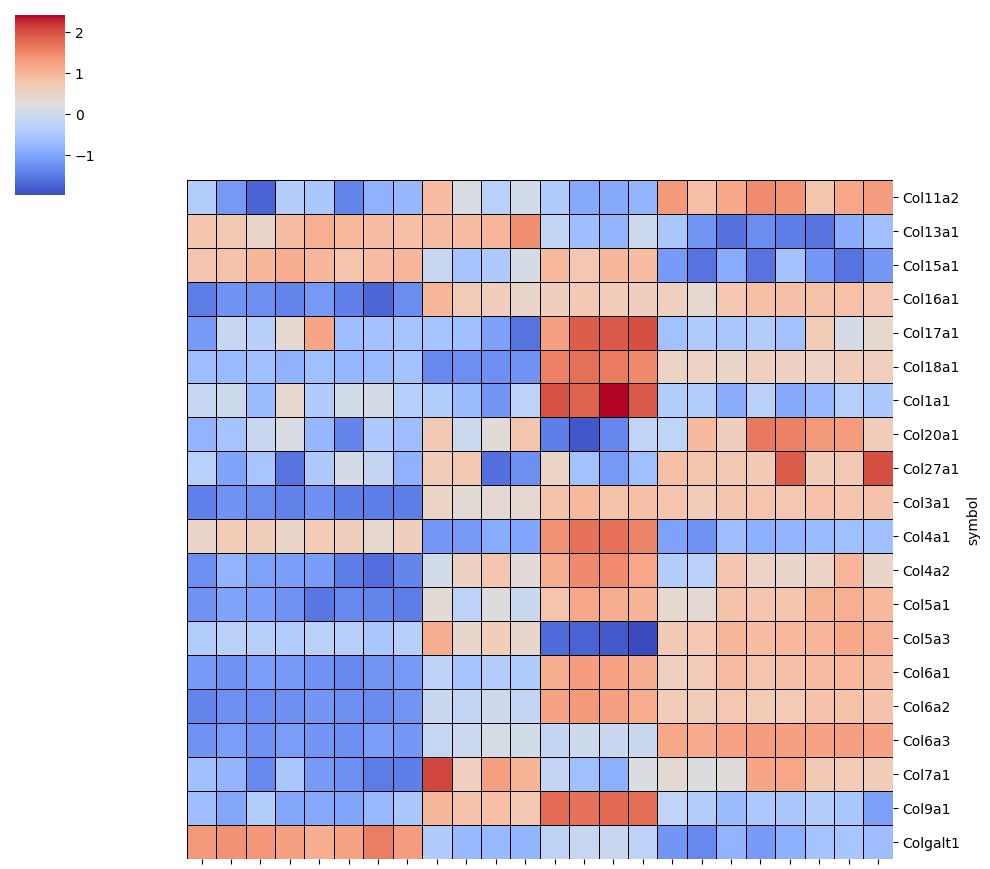

In [186]:
heatmap_collagen(relate_collagen)

In [187]:
collagen_order = ['Ccr7','Pdpn','Col16a1','Col3a1','Col7a1','Col20a1','Col5a3','Col15a1','Col4a1','Col5a1','Col6a1','Col6a2','Col18a1','Col17a1','Col1a1','Col13a1','Col6a3','Col9a1']

In [188]:

# 读取GMT文件
gmt_file = '/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.v2023.2.Mm.gmt'
gmt_data = gp.parser.read_gmt(gmt_file)

# 筛选出以 'col' 开头的基因并存储到列表中
col_genes = [gene for gene_set in gmt_data.values() for gene in gene_set if gene.startswith('Col')]

# 输出结果
print(col_genes)


['Col11a1', 'Col12a1', 'Col16a1', 'Col1a1', 'Col1a2', 'Col3a1', 'Col4a1', 'Col4a2', 'Col5a1', 'Col5a2', 'Col5a3', 'Col6a2', 'Col6a3', 'Col7a1', 'Col8a2', 'Colgalt1']


In [203]:
col_genes=['Col4a1','Col5a3','Col6a3','Col4a2','Col16a1','Col3a1','Col5a1','Col6a2','Ccr7','Pdpn']

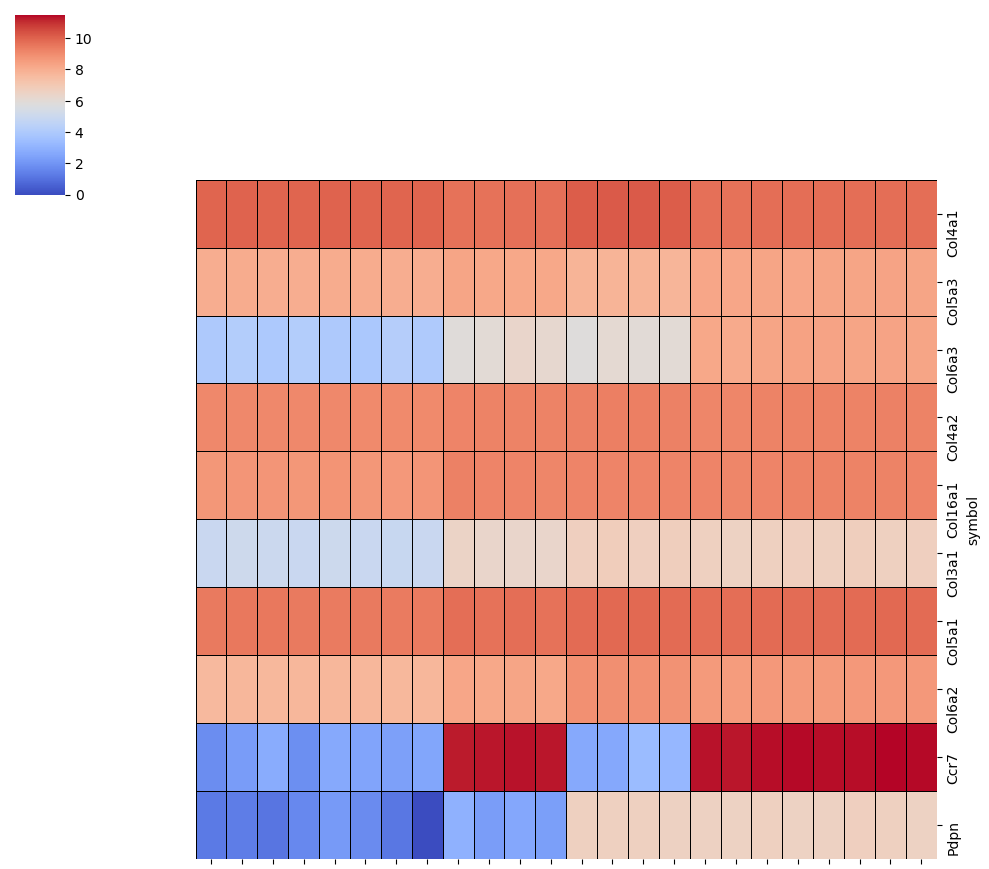

In [208]:
heatmap_collagen(col_genes)

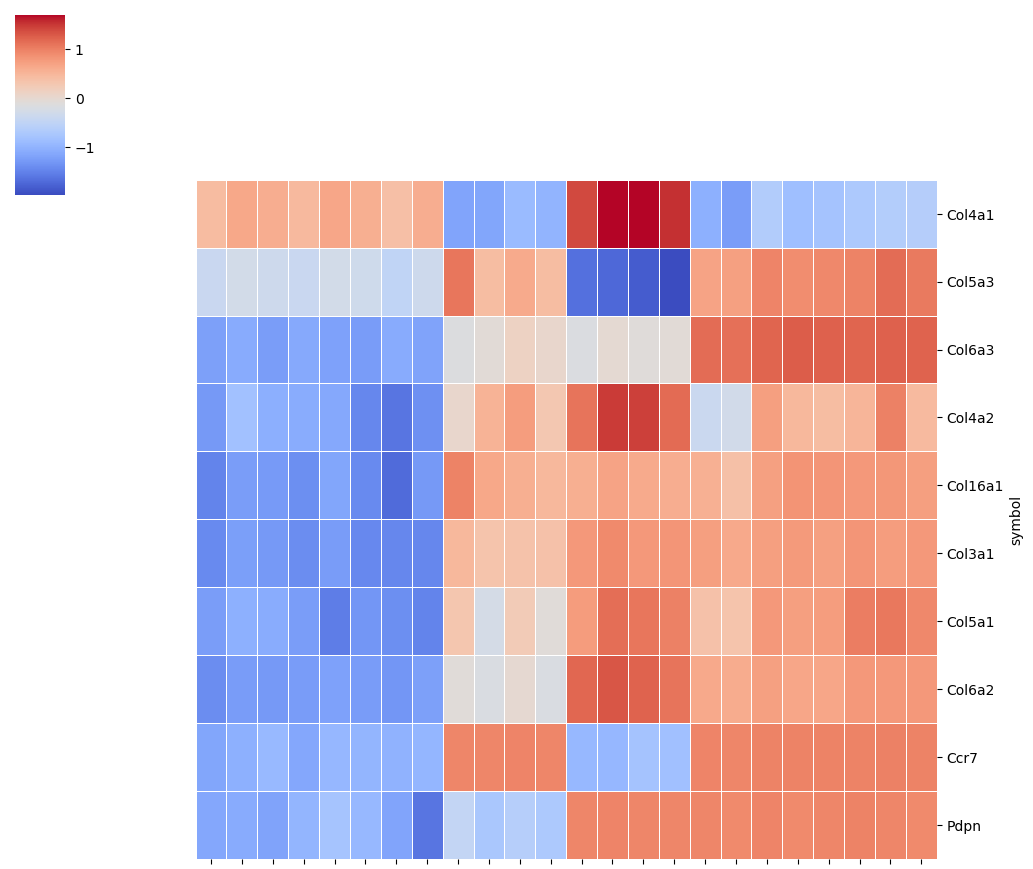

In [209]:
heatmap_3(col_genes,'collagen genes')

In [192]:
order_req_2 = ['X2_PDPN+_2','X2_PDPN+_4','X2_PDPN+_1','X2_PDPN+_3','X2_PDPN-_2','X2_PDPN-_3','X2_PDPN-_1','X2_PDPN-_6','X2_PDPN-_8','X2_PDPN-_7','X2_PDPN-_5','X2_PDPN-_4',]

In [193]:
collagen_human = ['Pdpn','Col11a1','Col12a1','Col16a1','Col1a1','Col1a2','Col3a1','Col4a1','Col4a2','Col5a1',
                 'Col5a2','Col5a3','Col6a2','Col6a3','Col7a1','Col8a2','Colgalt1']

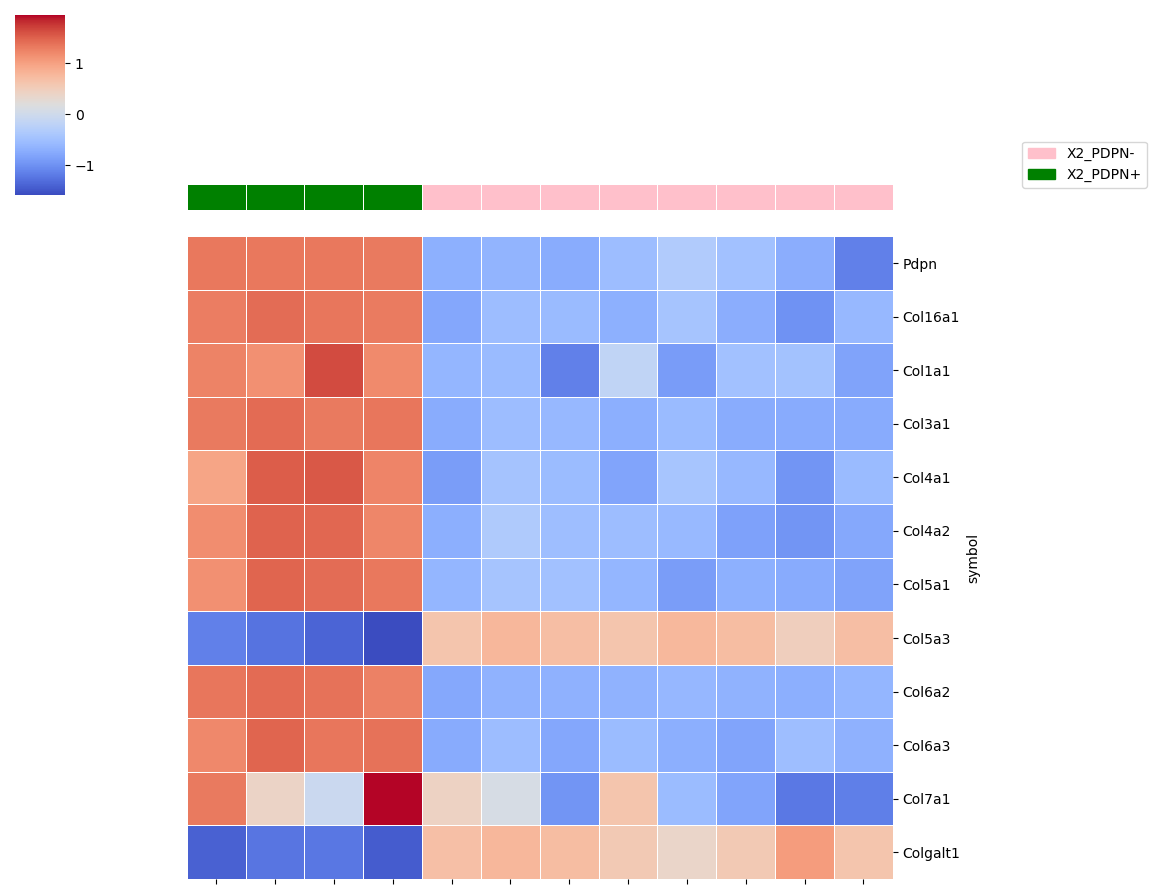

In [194]:
heatmap_real_1(collagen_human,'collagen genes')

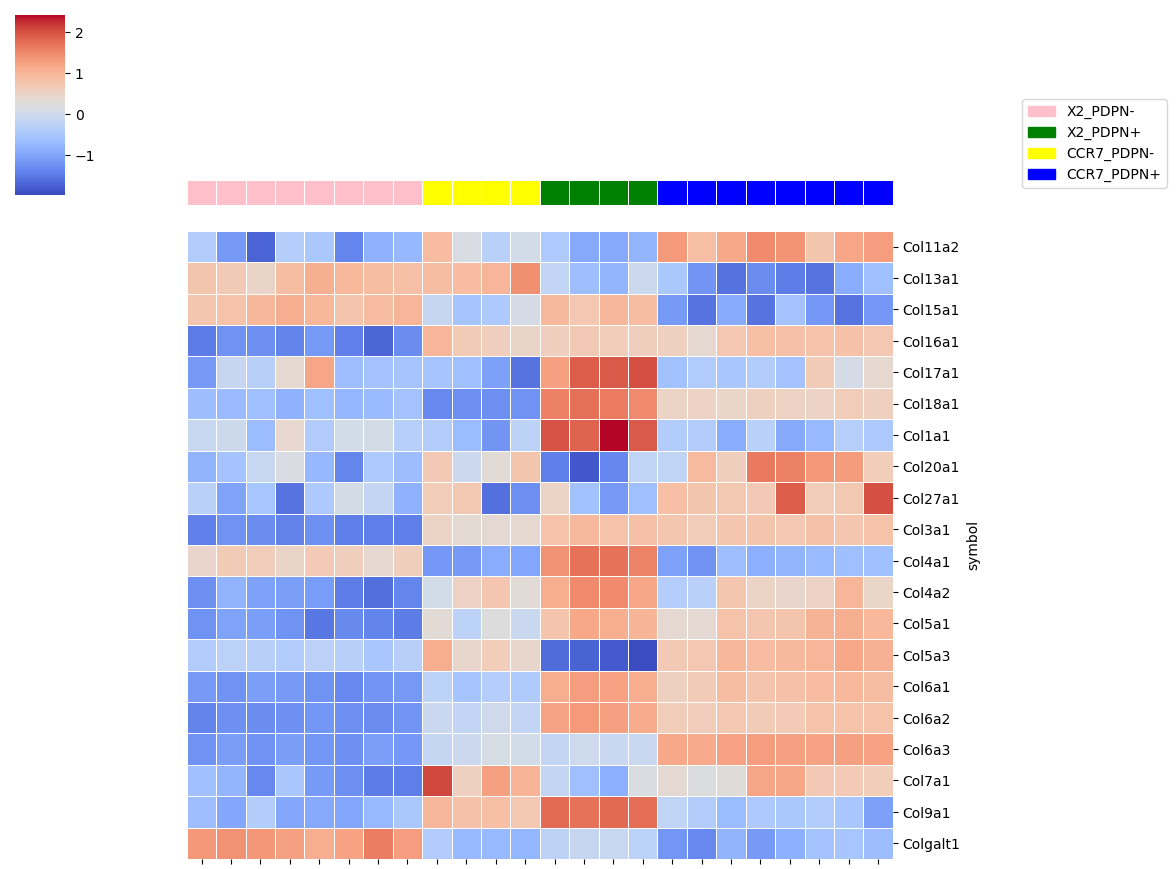

In [195]:
heatmap_real_col(relate_collagen,'collagen genes')

# Venn Diagram

In [301]:
up_Ctrl_vs_CPPN_me_set = set(up_Ctrl_vs_CPPN_me.index.unique())
up_Ctrl_vs_CNPP_me_set = set(up_Ctrl_vs_CNPP_me.index.unique())
up_CNPP_vs_CPPP_me_set = set(up_CPPPvsCNPP_me.index.unique())
up_CPPN_vs_CPPP_me_set = set(up_CPPPvsCPPN_me.index.unique())
up_Ctrl_vs_CPPP_me_set = set(up_Ctrl_vs_CPPP_me.index.unique())

In [302]:
down_Ctrl_vs_CPPN_me_set = set(down_Ctrl_vs_CPPN_me.index.unique())
down_Ctrl_vs_CNPP_me_set = set(down_Ctrl_vs_CNPP_me.index.unique())
down_CNPP_vs_CPPP_me_set = set(down_CPPPvsCNPP_me.index.unique())
down_CPPPvsCPPN_me_set = set(down_CPPPvsCPPN_me.index.unique())
down_Ctrl_vs_CPPP_me_set = set(down_Ctrl_vs_CPPP_me.index.unique())

In [303]:
# 计算交集
intersection_ctrl_vs_cnpp_and_cppn_vs_cppp = up_Ctrl_vs_CNPP_me_set & up_CPPN_vs_CPPP_me_set
intersection_ctrl_vs_cppn_and_cnpp_vs_cppp = up_Ctrl_vs_CPPN_me_set & up_CNPP_vs_CPPP_me_set

# 在 up_Ctrl_vs_CPPP_me_set 中抛出两个交集
result_set = up_Ctrl_vs_CPPP_me_set - intersection_ctrl_vs_cnpp_and_cppn_vs_cppp - intersection_ctrl_vs_cppn_and_cnpp_vs_cppp

# 打印结果
#print("Intersection of up_Ctrl_vs_CNPP and up_CPPN_vs_CPPP:", intersection_ctrl_vs_cnpp_and_cppn_vs_cppp)
#print("Intersection of up_Ctrl_vs_CPPN and up_CNPP_vs_CPPP:", intersection_ctrl_vs_cppn_and_cnpp_vs_cppp)
#print("Result set after removing intersections from up_Ctrl_vs_CPPP:", result_set)
print(len(intersection_ctrl_vs_cnpp_and_cppn_vs_cppp))
print(len(intersection_ctrl_vs_cppn_and_cnpp_vs_cppp))
print(len(up_Ctrl_vs_CPPP_me_set))
print("Number of elements in result set:", len(result_set))

29
200
522
Number of elements in result set: 333


In [304]:
intersection_ctrl_vs_cnpp_and_cppn_vs_cppp_down = down_Ctrl_vs_CNPP_me_set & down_CPPPvsCPPN_me_set
intersection_ctrl_vs_cppn_and_cnpp_vs_cppp_down = down_Ctrl_vs_CPPN_me_set & down_CNPP_vs_CPPP_me_set

# 在 up_Ctrl_vs_CPPP_me_set 中抛出两个交集
result_set_down = down_Ctrl_vs_CPPP_me_set - intersection_ctrl_vs_cnpp_and_cppn_vs_cppp_down - intersection_ctrl_vs_cppn_and_cnpp_vs_cppp_down
print(len(intersection_ctrl_vs_cnpp_and_cppn_vs_cppp_down))
print(len(intersection_ctrl_vs_cppn_and_cnpp_vs_cppp_down))
print(len(result_set_down))

108
301
351


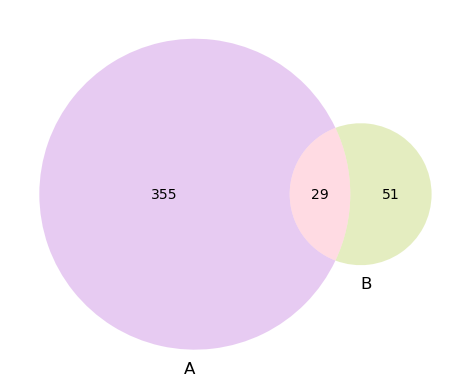

In [305]:
pdpn_V_up = venn2(subsets= (up_Ctrl_vs_CNPP_me_set, up_CPPN_vs_CPPP_me_set))#set_labels = ('X2 PDPN- vs CCR7+ PDPN+', 'X2 PDPN- vs X2 PDPN+'))

for region in ['10', '01', '11']:  
    patch = pdpn_V_up.get_patch_by_id(region)
    if patch:
        if region == '10':
            patch.set_facecolor('#C47EDF') 
        elif region == '01':
            patch.set_facecolor('#BDD463')     
        elif region == '11':
            patch.set_facecolor('#FFA6B9')
        
#lbl_v_pdpn_up = pdpn_V_up.get_label_by_id("B")
#x_v_pdpn_up, y_v_pdpn_up = lbl_v_pdpn_up.get_position()
#lbl_v_pdpn_up.set_position((x_v_pdpn_up, y_v_pdpn_up-0.065))

#plt.title('Up-Regulate Genes')
plt.show()

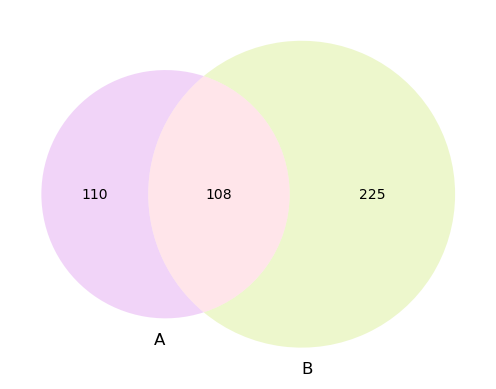

In [306]:
pdpn_V_down = venn2([down_Ctrl_vs_CNPP_me_set, down_CPPPvsCPPN_me_set]) #('X2 PDPN- vs CCR7+ PDPN+', 'X2 PDPN- vs X2 PDPN+'))

for region in ['10', '01', '11']:  
    patch = pdpn_V_down.get_patch_by_id(region)
    if patch:
        if region == '10':
            patch.set_facecolor('#dc95ef') 
        elif region == '01':
            patch.set_facecolor('#D3EB81')     
        elif region == '11':
            patch.set_facecolor('pink')
#lbl_v_pdpn_down = pdpn_V_down.get_label_by_id("B")
#x_v_pdpn_down,y_v_pdpn_down = lbl_v_pdpn_down.get_position()
#lbl_v_pdpn_down.set_position((x_v_pdpn_down,y_v_pdpn_down-0.241))

#plt.title('Down-Regulate Genes')
plt.show()

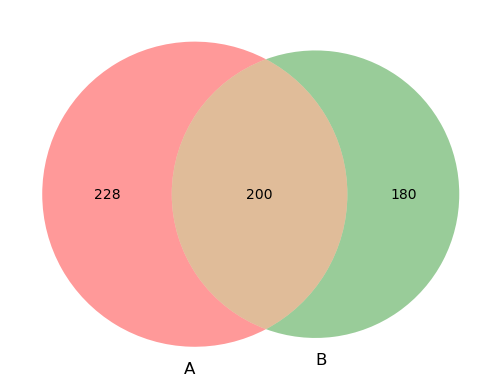

In [307]:
ccr7_V_up = venn2([up_Ctrl_vs_CPPN_me_set, up_CNPP_vs_CPPP_me_set])#, ('X2 PDPN- vs CCR7+ PDPN-', 'X2 PDPN+ vs CCR7+ PDPN+'))

#for region in ['10', '01', '11']:  
    #patch = ccr7_V_up.get_patch_by_id(region)
    #if patch:
        #if region == '10':
            #patch.set_facecolor('#5D3A8E') 
        #elif region == '01':
            #patch.set_facecolor('#5b8ecd')     
        #elif region == '11':
            #patch.set_facecolor('#fecacc')
            
#lbl_v_ccr7_up = ccr7_V_up.get_label_by_id("B")
#x_v_ccr7_up, y_v_ccr7_up = lbl_v_ccr7_up.get_position()
#lbl_v_ccr7_up.set_position((x_v_ccr7_up, y_v_ccr7_up-0.03798))


#plt.title('CCR7 Dependence of Up-Regulate Genes')
plt.show()

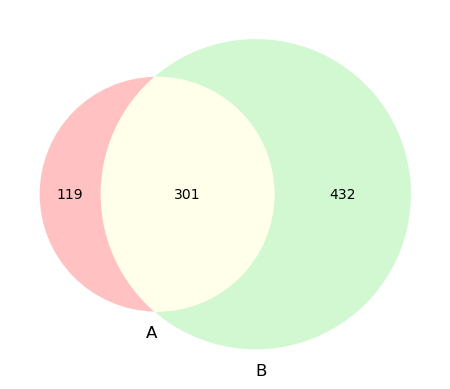

In [308]:
ccr7_V_down = venn2([down_Ctrl_vs_CPPN_me_set, down_CNPP_vs_CPPP_me_set])#, ('X2 PDPN- vs CCR7+ PDPN-', 'X2 PDPN+ vs CCR7+ PDPN+'))

for region in ['10', '01', '11']:  
    patch = ccr7_V_down.get_patch_by_id(region)
    if patch:
        if region == '10':
            patch.set_facecolor('#FF6666') 
        elif region == '01':
            patch.set_facecolor('#90EE90')     
        elif region == '11':
            patch.set_facecolor('#FFFFCC')

#lbl_v_ccr7_down = ccr7_V_down.get_label_by_id("A")
#x_v_ccr7_down, y_v_ccr7_down = lbl_v_ccr7_down.get_position()
#lbl_v_ccr7_down.set_position((x_v_ccr7_down, y_v_ccr7_down-0.124))

#plt.title('Down-Regulate Genes')
plt.show()

# Voline plot

In [239]:
#tpm_me_vp = tpm_me.copy()

In [ ]:
#tpm_me_vp=tpm_me_vp.T

In [ ]:
#tpm_me_vp.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
#tpm_me_vp.set_index('symbol',inplace = True)

In [ ]:
#df_long = heatmap_GOI.reset_index().melt(id_vars='symbol', var_name='Genotype', value_name='lograwcounts')

In [ ]:
#df_long

In [ ]:
#df_long = df_long.set_index('symbol')

In [ ]:
#erbb2_row = df_long.loc['Erbb2']

In [ ]:
#erbb2_row

# Combination of DEGs from different comparison 

# don't run it again
gsea(b)

add_prefix_to_columns(res_CNPP_vs_CPPN_results_me,'x2pp_vs_pm ')

In [ ]:
#add_prefix_to_columns(res_CNPP_vs_CPPP_results_me,'x2pp_vs_pp ')

In [ ]:
#add_prefix_to_columns(res_CPPN_vs_CPPP_results_me,'pm_vs_pp ')

In [ ]:
#add_prefix_to_columns(res_Ctrl_vs_CNPP_results_me,'ctrl_vs_x2pp ')

In [ ]:
#add_prefix_to_columns(res_Ctrl_vs_CPPP_results_me,'ctrl_vs_pp ')

In [ ]:
#add_prefix_to_columns(res_Ctrl_vs_CPPN_results_me,'ctrl_vs_pm ')

In [ ]:
#dfs=[res_Ctrl_vs_CPPN_results_me,res_Ctrl_vs_CPPP_results_me,res_Ctrl_vs_CNPP_results_me,
    #res_CNPP_vs_CPPN_results_me,res_CNPP_vs_CPPP_results_me,res_CPPN_vs_CPPP_results_me]

In [ ]:
#DEG_combined = pd.concat(dfs,axis=1)

In [ ]:
#DEG_combined

In [ ]:
#DEG_combined.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']

In [ ]:
#save(DEG_combined,'Diffexpres')

# Combination of two excels - DEGs

In [ ]:
# don't run it again
#gsea()

In [ ]:
#excel_068 = pd.read_csv('DiffGeneExpAnalysis_filtered_068.csv',index_col=0)
#excel_122 = pd.read_csv('DiffGeneExpAnalysis_Flt_122.csv',index_col=0)

In [ ]:
#result = pd.concat([excel_068, excel_122], axis=1, join='outer')

In [ ]:
#result

In [ ]:
#save(result,'combination_068&122')

In [ ]:
#combination_downregualtion = pd.read_csv('combination_downregulation.csv',index_col=0)

hallmark_enrichment(combination_downregualtion)

combination_upregualtion = pd.read_csv('combination_upregulation.csv',index_col=0)
hallmark_enrichment(combination_upregualtion)

In [ ]:
# Combination of two excels - Rawcounts

In [ ]:
#excel_068_rawcounts = pd.read_csv('068_rawcounts.csv',index_col=0)
#excel_122_rawcounts = pd.read_csv('122_rawcounts.csv',index_col=0)

In [ ]:
#result_rawcounts = pd.concat([excel_068_rawcounts, excel_122_rawcounts], axis=1, join='outer')

In [ ]:
#save(result_rawcounts,'combination_rawcounts')

In [ ]:
#from Bio import Entrez